In [1]:
import pandas as pd
df = pd.read_csv(r"C:\Users\David\Documents\Albert school\Carmila alberton\Data for the CARMILA challenge\Dataset pour le ML\df_ml_fe_oe_with_weather.csv")

C:\Users\David\AppData\Local\Temp\ipykernel_20536\1534951410.py:2: DtypeWarning: Columns (15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r"C:\Users\David\Documents\Albert school\Carmila alberton\Data for the CARMILA challenge\Dataset pour le ML\df_ml_fe_oe_with_weather.csv")


In [3]:
df.head()

,date,Entrées,Mall ID,is_open,hour,day_of_week,month,sunrise,sunset,ds,sun_up,fermeture_exceptionnelle,ouverture_exceptionnelle,Gazole,Sans plomb 98,SP 95 E10,Superéthanol E85,weather
0,2023-01-01,0.0,53,0,0,6,1,2023-01-01 07:03:02+00:00,2023-01-01 16:06:50+00:00,2022-12-31 23:00:00+00:00,0,0,0,1.729,1.859,1.779,0.9,1
1,2023-01-01,0.0,53,0,1,6,1,2023-01-01 07:03:02+00:00,2023-01-01 16:06:50+00:00,2023-01-01 00:00:00+00:00,0,0,0,1.729,1.859,1.779,0.9,1
2,2023-01-01,0.0,53,0,2,6,1,2023-01-01 07:03:02+00:00,2023-01-01 16:06:50+00:00,2023-01-01 01:00:00+00:00,0,0,0,1.729,1.859,1.779,0.9,1
3,2023-01-01,0.0,53,0,3,6,1,2023-01-01 07:03:02+00:00,2023-01-01 16:06:50+00:00,2023-01-01 02:00:00+00:00,0,0,0,1.729,1.859,1.779,0.9,1
4,2023-01-01,0.0,53,0,4,6,1,2023-01-01 07:03:02+00:00,2023-01-01 16:06:50+00:00,2023-01-01 03:00:00+00:00,0,0,0,1.729,1.859,1.779,0.9,1


In [4]:
# 1. INSPECTION INITIALE DES DONNÉES

def initial_inspection(df):
    print("Aperçu des données :")
    print(df.head())
    print("\nStatistiques descriptives :")
    print(df.describe(include='all'))
    print("\nInfos :")
    print(df.info())

# 2. PRÉPROCESSING DE BASE
def basic_preprocessing(df):
    # Tri par Mall ID puis par date/heure (important pour les séries temporelles multi-centres)
    df = df.sort_values(by=['Mall ID', 'date', 'hour']).reset_index(drop=True)
    
    # Conversion de hour en int (si nécessaire)
    df['hour'] = df['hour'].astype(int)
    
    # Conversion des colonnes de fermeture/ouverture exceptionnelle si elles existent
    if 'fermeture_exceptionnelle' in df.columns:
        df['fermeture_exceptionnelle'] = df['fermeture_exceptionnelle'].astype(int)
    if 'ouverture_exceptionnelle' in df.columns:
        df['ouverture_exceptionnelle'] = df['ouverture_exceptionnelle'].astype(int)

    # Conversion de la colonne 'weather' en int si elle existe
    if 'weather' in df.columns:
        df['weather'] = df['weather'].astype(int)
    
    return df

# Inspection initiale\initial_inspection(df)

# Préprocessing
df = basic_preprocessing(df)

# Affichage d'un échantillon
print(df.head())

         date  Entrées  Mall ID  is_open  hour  day_of_week  month  \
0  2023-01-01      0.0        5        0     0            6      1   
1  2023-01-01      0.0        5        0     1            6      1   
2  2023-01-01      0.0        5        0     2            6      1   
3  2023-01-01      0.0        5        0     3            6      1   
4  2023-01-01      0.0        5        0     4            6      1   

                     sunrise                     sunset  \
0  2023-01-01 07:55:03+00:00  2023-01-01 16:25:15+00:00   
1  2023-01-01 07:55:03+00:00  2023-01-01 16:25:15+00:00   
2  2023-01-01 07:55:03+00:00  2023-01-01 16:25:15+00:00   
3  2023-01-01 07:55:03+00:00  2023-01-01 16:25:15+00:00   
4  2023-01-01 07:55:03+00:00  2023-01-01 16:25:15+00:00   

                          ds  sun_up  fermeture_exceptionnelle  \
0  2022-12-31 23:00:00+00:00       0                         0   
1  2023-01-01 00:00:00+00:00       0                         0   
2  2023-01-01 01:00:00+00:

In [48]:
import numpy as np
import pandas as pd

def feature_engineering(df):
    """
    Convertit sunrise/sunset en datetime, calcule la durée d'ensoleillement,
    ajoute une variable is_weekend et encode le mois de manière cyclique.
    """
    # 1. Convertir sunrise et sunset en datetime si ce n'est pas déjà le cas
    df['sunrise'] = pd.to_datetime(df['sunrise'], errors='coerce')
    df['sunset'] = pd.to_datetime(df['sunset'], errors='coerce')

    # 2. Durée d’ensoleillement (en heures)
    df['daylight_duration'] = (df['sunset'] - df['sunrise']).dt.total_seconds() / 3600

    # 3. Variable week-end (day_of_week = 0 pour lundi, 6 pour dimanche)
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    
    # 4. Encodage cyclique du mois (si month = 1,...,12)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    
    return df

def handle_outliers(df, col='Entrées', method='iqr', factor=1.5):
    """
    Capping via IQR : remplace les valeurs > (Q3 + factor*IQR) par ce seuil,
    pour limiter l'impact des valeurs extrêmes.
    """
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + factor * IQR

    # Capping
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
    return df

# Exemple d’utilisation
if __name__ == "__main__":
    # On suppose que df est déjà chargé dans ton environnement
    df = feature_engineering(df)
    df = handle_outliers(df, col='Entrées')
    print(df.head())


         date  Entrées  Mall ID  is_open  hour  day_of_week  month  \
0  2023-01-01      0.0       53        0     0            6      1   
1  2023-01-01      0.0       53        0     1            6      1   
2  2023-01-01      0.0       53        0     2            6      1   
3  2023-01-01      0.0       53        0     3            6      1   
4  2023-01-01      0.0       53        0     4            6      1   

                    sunrise                    sunset                  ds  \
0 2023-01-01 07:03:02+00:00 2023-01-01 16:06:50+00:00 2022-12-31 23:00:00   
1 2023-01-01 07:03:02+00:00 2023-01-01 16:06:50+00:00 2023-01-01 00:00:00   
2 2023-01-01 07:03:02+00:00 2023-01-01 16:06:50+00:00 2023-01-01 01:00:00   
3 2023-01-01 07:03:02+00:00 2023-01-01 16:06:50+00:00 2023-01-01 02:00:00   
4 2023-01-01 07:03:02+00:00 2023-01-01 16:06:50+00:00 2023-01-01 03:00:00   

   ...  Sans plomb 98  SP 95 E10  Superéthanol E85  weather  unique_id    y  \
0  ...          1.859      1.779     

In [6]:
df.columns

Index(['date', 'Entrées', 'Mall ID', 'is_open', 'hour', 'day_of_week', 'month',
       'sunrise', 'sunset', 'ds', 'sun_up', 'fermeture_exceptionnelle',
       'ouverture_exceptionnelle', 'Gazole', 'Sans plomb 98', 'SP 95 E10',
       'Superéthanol E85', 'weather', 'daylight_duration', 'is_weekend',
       'month_sin', 'month_cos'],
      dtype='object')

In [6]:
import numpy as np
import pandas as pd

# Define extreme outlier threshold for "Entrées"
Q1 = df["Entrées"].quantile(0.25)
Q3 = df["Entrées"].quantile(0.75)
IQR = Q3 - Q1
extreme_upper_bound = Q3 + 3.99 * IQR  # Stricter threshold

# Filter only extreme outliers
extreme_outliers = df[df["Entrées"] > extreme_upper_bound]

# Display the extreme outliers
print(extreme_outliers)


             date  Entrées  Mall ID  is_open  hour  day_of_week  month  \
26103  2023-12-23   4369.0       38        1    15            5     12   
34599  2024-12-11   4210.0       38        1    15            2     12   
34839  2024-12-21   4283.0       38        1    15            5     12   
34887  2024-12-23   4293.0       38        1    15            0     12   

                         sunrise                     sunset  \
26103  2023-12-23 07:35:52+00:00  2023-12-23 16:26:37+00:00   
34599  2024-12-11 07:28:30+00:00  2024-12-11 16:23:02+00:00   
34839  2024-12-21 07:35:17+00:00  2024-12-21 16:25:57+00:00   
34887  2024-12-23 07:36:11+00:00  2024-12-23 16:27:02+00:00   

                              ds  sun_up  fermeture_exceptionnelle  \
26103  2023-12-23 14:00:00+00:00       1                         0   
34599  2024-12-11 14:00:00+00:00       1                         0   
34839  2024-12-21 14:00:00+00:00       1                         0   
34887  2024-12-23 14:00:00+00:00 

Ajout de ML flow avant le ML

In [7]:
import mlflow
import mlflow.sklearn

In [8]:
tracking_uri = mlflow.get_tracking_uri()  # Stocke le tracking URI dans une variable
print(tracking_uri)  # Affiche le tracking URI si besoin

file:///c:/Users/David/Documents/Albert%20school/Carmila%20alberton/Data%20for%20the%20CARMILA%20challenge/mlruns


In [9]:
mlflow.set_tracking_uri(tracking_uri)  # Définit le tracking URI à partir de la variable

In [10]:
mlflow.end_run()

In [11]:
with mlflow.start_run() as run:
    print(f"Run ID: {run.info.run_id}")
    print(f"Experiment ID: {run.info.experiment_id}")

Run ID: 8de2f682415b4a51bc1de489e33c76f6
Experiment ID: 0


In [12]:
mlflow.set_tracking_uri("file:///c:/Users/David/Documents/Albert%20school/Carmila%20alberton/Data%20for%20the%20CARMILA%20challenge/mlruns")

cd C:\Users\David\Documents\Albert school\Carmila alberton\Data for the CARMILA challenge

Mlflow ui

sans 
is_open
sunrise
sunset
sun_up
fermeture_exceptionnelle
ouverture_exceptionnelle
Gazole, Sans plomb 98, SP 95 E10, Superéthanol E85 (Fuel prices)
weather

Nombre de lignes en train : 160810
Nombre de lignes en test  : 14630
Horizon par série : 1463
Colonnes du forecast : ['unique_id', 'ds', 'LGBMRegressor']

=== Métriques Globales ===
RMSE : 400.0224
MAE  : 218.7847


2025/02/05 21:27:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


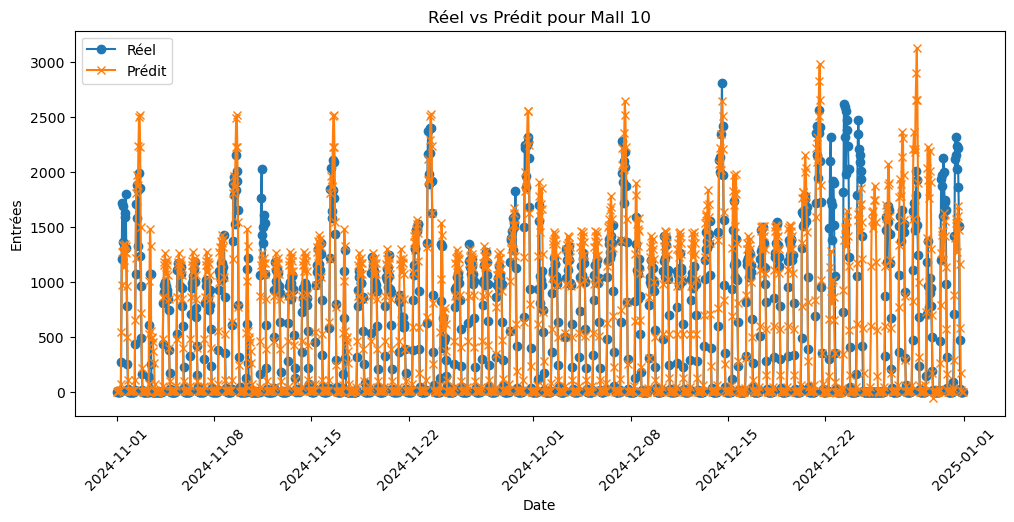

In [47]:
import pandas as pd
import numpy as np
import mlflow
import mlflow.lightgbm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from mlforecast import MLForecast
from lightgbm import LGBMRegressor

# -----------------------------------------------------------------
# 1) Préparation des données
# -----------------------------------------------------------------
def prepare_data(df):
    if 'Mall ID' in df.columns:
        df['unique_id'] = df['Mall ID'].astype(str)
    else:
        raise KeyError("La colonne 'Mall ID' est manquante.")
    if 'datetime' in df.columns:
        # Ici, on enlève la timezone pour rester tz-naïf
        df['ds'] = pd.to_datetime(df['datetime']).dt.tz_localize(None)
    elif 'ds' in df.columns:
        df['ds'] = pd.to_datetime(df['ds']).dt.tz_localize(None)
    else:
        raise KeyError("Aucune colonne 'datetime' ou 'ds' trouvée.")
    if 'Entrées' in df.columns:
        df['y'] = df['Entrées']
    else:
        raise KeyError("La colonne 'Entrées' est manquante.")
    return df[['unique_id', 'ds', 'y']].sort_values(['unique_id', 'ds']).reset_index(drop=True)

# On part du DataFrame déjà chargé "df"
df_prepared = prepare_data(df)

# -----------------------------------------------------------------
# 2) Split Train/Test (avec votre cutoff d'origine)
# -----------------------------------------------------------------
cutoff = pd.to_datetime('2024-10-31 23:59:59')  # cutoff d'origine
train_df = df_prepared[df_prepared['ds'] <= cutoff].copy()
test_df  = df_prepared[df_prepared['ds'] > cutoff].copy()

print("Nombre de lignes en train :", len(train_df))
print("Nombre de lignes en test  :", len(test_df))

# -----------------------------------------------------------------
# 3) Configuration MLForecast avec LightGBM
# -----------------------------------------------------------------
models = [
    LGBMRegressor(
        objective='regression',
        boosting_type='gbdt',
        verbosity=-1,
        random_state=42
    )
]

# Utilisation de MLForecast avec fréquence horaire ('h')
fcst = MLForecast(
    models=models,
    freq='h',
    lags=[1],
    date_features=['hour', 'day', 'dayofweek', 'month']
)

# Entraînement sur le jeu train
fcst.fit(train_df)

# La prévision est faite pour un horizon par série.
# Ici, MLForecast prévoit pour chaque série h périodes,
# où h = (nombre de lignes de test) / (nombre de séries).
n_series = train_df['unique_id'].nunique()
horizon = len(test_df) // n_series
print("Horizon par série :", horizon)

forecast = fcst.predict(h=horizon)
print("Colonnes du forecast :", forecast.columns.tolist())
pred_col = "LGBMRegressor"  # d'après votre sortie

# -----------------------------------------------------------------
# 4) Aligner les timestamps pour la fusion
# -----------------------------------------------------------------
# Pour garantir une fusion exacte, on "arrondit" les timestamps à l'heure.
train_df['ds_aligned'] = train_df['ds'].dt.floor('h')
test_df['ds_aligned'] = test_df['ds'].dt.floor('h')
forecast['ds_aligned'] = forecast['ds'].dt.floor('h')

# Fusionner test_df et forecast sur unique_id et ds_aligned.
df_merge = pd.merge(test_df, forecast[['unique_id','ds_aligned', pred_col]],
                    left_on=['unique_id','ds_aligned'],
                    right_on=['unique_id','ds_aligned'],
                    how='left')

if df_merge[pred_col].isna().any():
    raise ValueError("Des valeurs manquent dans la fusion entre test_df et forecast.")

y_pred = df_merge[pred_col].values
y_true = df_merge["y"].values

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae  = mean_absolute_error(y_true, y_pred)

print("\n=== Métriques Globales ===")
print(f"RMSE : {rmse:.4f}")
print(f"MAE  : {mae:.4f}")

# -----------------------------------------------------------------
# 5) Enregistrement avec MLflow
# -----------------------------------------------------------------
mlflow.set_experiment("Carmila")
with mlflow.start_run():
    mlflow.set_tag("mlflow.runName", "MLForecast_LightGBM")
    mlflow.log_metric("RMSE", rmse)
    mlflow.log_metric("MAE", mae)
    mlflow.lightgbm.log_model(models[0], "lightgbm_model")

# -----------------------------------------------------------------
# 6) Visualisation des prédictions (pour une série, par exemple le premier unique_id)
# -----------------------------------------------------------------
unique_id_example = df_merge["unique_id"].unique()[0]
df_plot = df_merge[df_merge["unique_id"] == unique_id_example].sort_values("ds")

plt.figure(figsize=(12, 5))
plt.plot(df_plot["ds"], df_plot["y"], label="Réel", marker="o")
plt.plot(df_plot["ds"], df_plot[pred_col], label="Prédit", marker="x")
plt.xlabel("Date")
plt.ylabel("Entrées")
plt.title(f"Réel vs Prédit pour Mall {unique_id_example}")
plt.legend()
plt.xticks(rotation=45)
plt.show()


Vérif si overfit

In [14]:
print(df[['y']].describe())


                   y
count  175440.000000
mean      435.749866
std       562.368079
min         0.000000
25%         0.000000
50%        46.000000
75%       837.000000
max      2092.500000


XGboost

nixtla xgboost

Nombre de lignes en train : 160810
Nombre de lignes en test  : 14630
Horizon par série : 1463
Colonnes du forecast : ['unique_id', 'ds', 'XGBRegressor']

=== Métriques Globales ===
RMSE : 369.7224
MAE  : 194.8565

=== Métriques par Centre Commercial ===
  unique_id        rmse         mae
0        10  273.452514  133.267887
1        11  294.309827  151.254001
2        19  294.845829  143.435153
3        20  475.199537  285.866951
4        37  341.145491  178.040884
5        38  455.826535  240.985745
6        47  305.969438  162.524195
7         5  373.175440  207.837907
8        53  299.140354  153.865594
9        71  496.268791  291.486301


C:\Users\David\AppData\Local\Temp\ipykernel_17196\1021014286.py:105: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics_per_mall = df_merge.groupby('unique_id').apply(


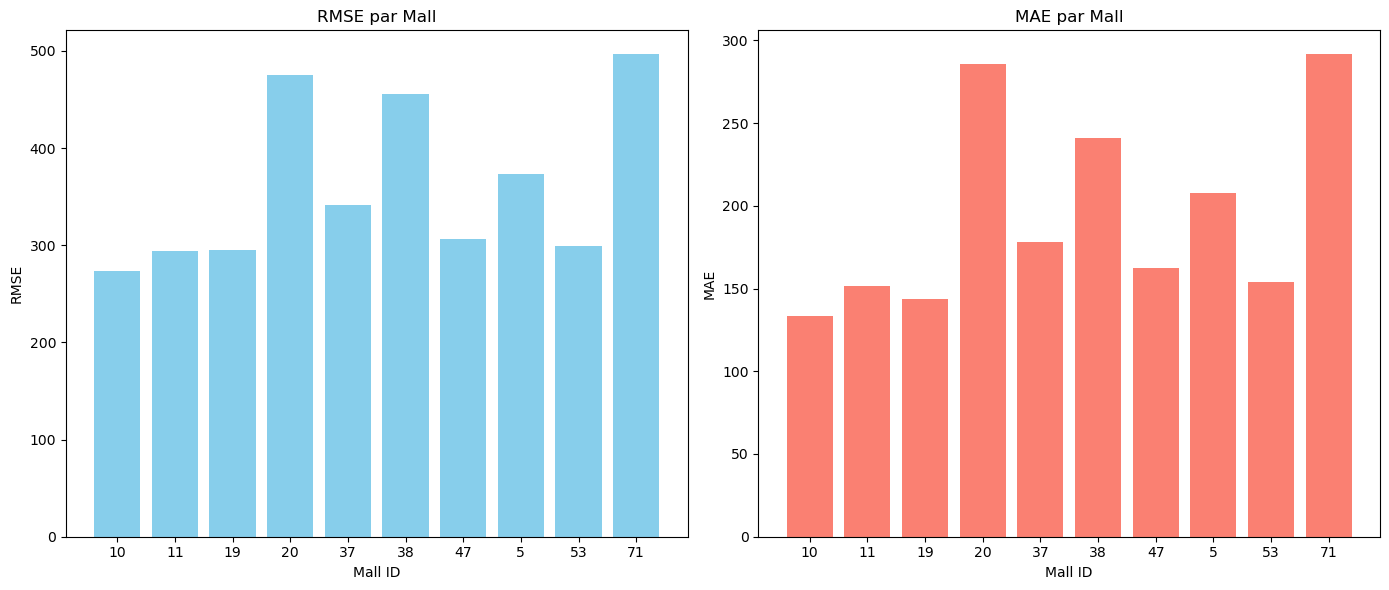

In [51]:
import pandas as pd
import numpy as np
import xgboost as xgb
import mlflow
import mlflow.xgboost
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from mlforecast import MLForecast

# -----------------------------------------------------------------
# 1) Préparation des données
# -----------------------------------------------------------------
def prepare_data(df):
    if 'Mall ID' in df.columns:
        df['unique_id'] = df['Mall ID'].astype(str)
    else:
        raise KeyError("La colonne 'Mall ID' est manquante.")
    if 'datetime' in df.columns:
        df['ds'] = pd.to_datetime(df['datetime']).dt.tz_localize(None)  # Retirer la timezone
    elif 'ds' in df.columns:
        df['ds'] = pd.to_datetime(df['ds']).dt.tz_localize(None)
    else:
        raise KeyError("Aucune colonne 'datetime' ou 'ds' trouvée.")
    if 'Entrées' in df.columns:
        df['y'] = df['Entrées']
    else:
        raise KeyError("La colonne 'Entrées' est manquante.")
    return df[['unique_id', 'ds', 'y']].sort_values(['unique_id', 'ds']).reset_index(drop=True)

# Supposons que votre DataFrame d'origine s'appelle "df"
df_prepared = prepare_data(df)

# -----------------------------------------------------------------
# 2) Split Train/Test (en gardant le cutoff d'origine)
# -----------------------------------------------------------------
cutoff = pd.to_datetime('2024-10-31 23:59:59')  # cutoff d'origine
train_df = df_prepared[df_prepared['ds'] <= cutoff].copy()
test_df  = df_prepared[df_prepared['ds'] > cutoff].copy()

print("Nombre de lignes en train :", len(train_df))
print("Nombre de lignes en test  :", len(test_df))

# -----------------------------------------------------------------
# 3) Configuration de MLForecast avec XGBoost
# -----------------------------------------------------------------
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'n_estimators': 500,
    'learning_rate': 0.05,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42
}

# Création du modèle XGBoost via XGBRegressor
model = xgb.XGBRegressor(**params)

# Configuration de MLForecast :
fcst = MLForecast(
    models=[model],
    freq='h',
    lags=[1],
    date_features=['hour', 'day', 'dayofweek', 'month']
)

# Entraînement
fcst.fit(train_df)

# Détermination de l'horizon par série
n_series = train_df['unique_id'].nunique()
horizon = len(test_df) // n_series
print("Horizon par série :", horizon)

# Prédictions
forecast = fcst.predict(h=horizon)
print("Colonnes du forecast :", forecast.columns.tolist())
pred_col = "XGBRegressor" if "XGBRegressor" in forecast.columns else "yhat"

# -----------------------------------------------------------------
# 4) Fusion et calcul des métriques (RMSE et MAE) par centre commercial
# -----------------------------------------------------------------
test_df['ds_aligned'] = test_df['ds'].dt.floor('h')
forecast['ds_aligned'] = forecast['ds'].dt.floor('h')

df_merge = pd.merge(test_df, forecast[['unique_id', 'ds_aligned', pred_col]],
                    on=['unique_id', 'ds_aligned'],
                    how='left')

if df_merge[pred_col].isna().any():
    raise ValueError("Des valeurs manquent dans la fusion entre test_df et forecast.")

y_true = df_merge["y"].values
y_pred = df_merge[pred_col].values

global_rmse = np.sqrt(mean_squared_error(y_true, y_pred))
global_mae  = mean_absolute_error(y_true, y_pred)

print("\n=== Métriques Globales ===")
print(f"RMSE : {global_rmse:.4f}")
print(f"MAE  : {global_mae:.4f}")

# Calcul des métriques par centre commercial (mall)
metrics_per_mall = df_merge.groupby('unique_id').apply(
    lambda g: pd.Series({
        'rmse': np.sqrt(mean_squared_error(g['y'], g[pred_col])),
        'mae': mean_absolute_error(g['y'], g[pred_col])
    })
).reset_index()

print("\n=== Métriques par Centre Commercial ===")
print(metrics_per_mall)

# -----------------------------------------------------------------
# 5) Visualisation des métriques par centre commercial
# -----------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].bar(metrics_per_mall['unique_id'], metrics_per_mall['rmse'], color='skyblue')
axes[0].set_title("RMSE par Mall")
axes[0].set_xlabel("Mall ID")
axes[0].set_ylabel("RMSE")

axes[1].bar(metrics_per_mall['unique_id'], metrics_per_mall['mae'], color='salmon')
axes[1].set_title("MAE par Mall")
axes[1].set_xlabel("Mall ID")
axes[1].set_ylabel("MAE")

plt.tight_layout()
plt.show()

# -----------------------------------------------------------------
# 6) Enregistrement des métriques avec MLflow (avec le bon nom de run)
# -----------------------------------------------------------------
mlflow.set_experiment("Carmila")
with mlflow.start_run():
    mlflow.set_tag("mlflow.runName", "nixtla xgboost")
    mlflow.log_params(params)
    mlflow.log_metric("RMSE", global_rmse)
    mlflow.log_metric("MAE", global_mae)


Nixtla Catboost

Nombre de lignes en train : 160810
Nombre de lignes en test  : 14630
0:	learn: 544.2227138	total: 16.8ms	remaining: 8.4s
50:	learn: 134.6420137	total: 671ms	remaining: 5.91s
100:	learn: 110.6282530	total: 1.35s	remaining: 5.33s
150:	learn: 103.0556736	total: 1.97s	remaining: 4.54s
200:	learn: 98.4153092	total: 2.55s	remaining: 3.79s
250:	learn: 95.6086603	total: 3.13s	remaining: 3.11s
300:	learn: 93.4372162	total: 3.72s	remaining: 2.46s
350:	learn: 91.8315486	total: 4.27s	remaining: 1.81s
400:	learn: 90.6196072	total: 4.83s	remaining: 1.19s
450:	learn: 89.7637102	total: 5.41s	remaining: 587ms
499:	learn: 89.0575723	total: 5.95s	remaining: 0us
Horizon par série : 1463
Colonnes du forecast : ['unique_id', 'ds', 'CatBoostRegressor']

=== Métriques Globales ===
RMSE : 447.9397
MAE  : 238.1353

=== Métriques par Centre Commercial ===
  unique_id        rmse         mae
0        10  326.576648  168.748508
1        11  307.312764  151.340450
2        19  421.015005  209.685141
3        20  60

C:\Users\David\AppData\Local\Temp\ipykernel_17196\2325384045.py:107: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics_per_mall = df_merge.groupby('unique_id').apply(


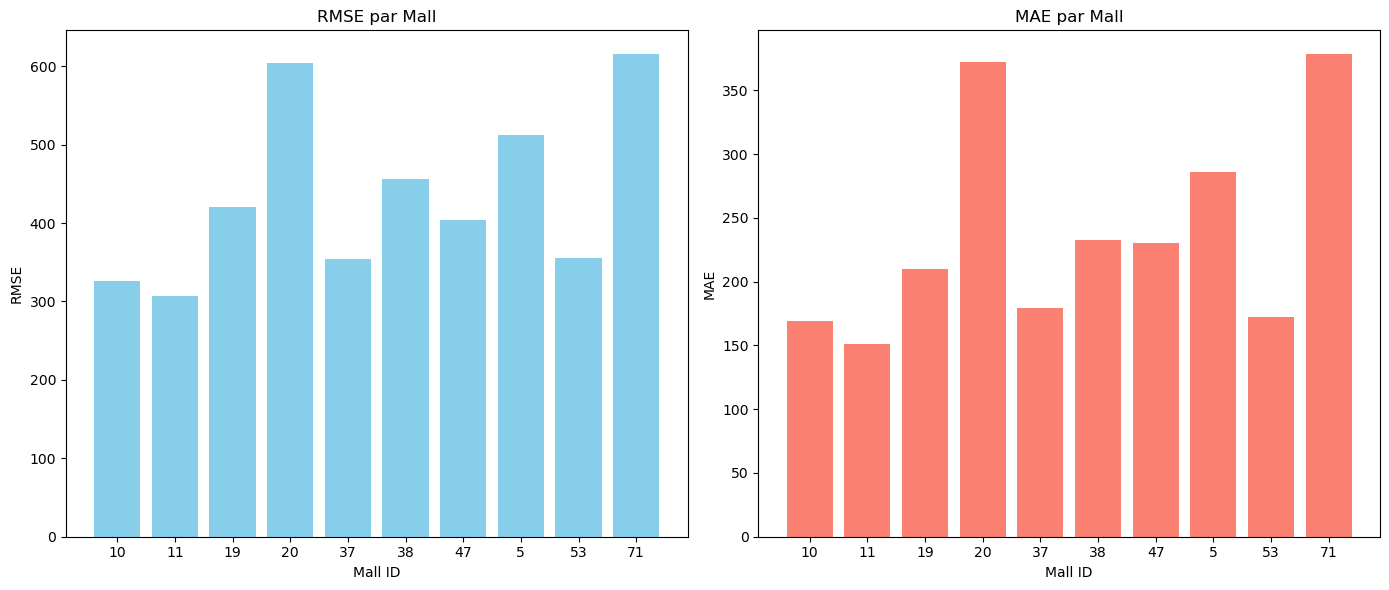

In [50]:
import pandas as pd
import numpy as np
import catboost as cb
import mlflow
import mlflow.catboost
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from mlforecast import MLForecast

# -----------------------------------------------------------------
# 1) Préparation des données
# -----------------------------------------------------------------
def prepare_data(df):
    if 'Mall ID' in df.columns:
        df['unique_id'] = df['Mall ID'].astype(str)
    else:
        raise KeyError("La colonne 'Mall ID' est manquante.")
    
    if 'datetime' in df.columns:
        df['ds'] = pd.to_datetime(df['datetime']).dt.tz_localize(None)  # Suppression de la timezone
    elif 'ds' in df.columns:
        df['ds'] = pd.to_datetime(df['ds']).dt.tz_localize(None)
    else:
        raise KeyError("Aucune colonne 'datetime' ou 'ds' trouvée.")
    
    if 'Entrées' in df.columns:
        df['y'] = df['Entrées']
    else:
        raise KeyError("La colonne 'Entrées' est manquante.")
    
    return df[['unique_id', 'ds', 'y']].sort_values(['unique_id', 'ds']).reset_index(drop=True)

# On suppose que le DataFrame initial s'appelle "df"
df_prepared = prepare_data(df)

# -----------------------------------------------------------------
# 2) Split Train/Test (cutoff d'origine)
# -----------------------------------------------------------------
cutoff = pd.to_datetime('2024-10-31 23:59:59')  # cutoff d'origine
train_df = df_prepared[df_prepared['ds'] <= cutoff].copy()
test_df  = df_prepared[df_prepared['ds'] > cutoff].copy()

print("Nombre de lignes en train :", len(train_df))
print("Nombre de lignes en test  :", len(test_df))

# -----------------------------------------------------------------
# 3) Configuration de MLForecast avec CatBoost
# -----------------------------------------------------------------
params = {
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
    'iterations': 500,
    'learning_rate': 0.05,
    'depth': 6,
    'random_seed': 42,
    'verbose': 50
}

# Création du modèle CatBoost
model = cb.CatBoostRegressor(**params)

# Configuration de MLForecast :
fcst = MLForecast(
    models=[model],
    freq='h',
    lags=[1],
    date_features=['hour', 'day', 'dayofweek', 'month']
)

# Entraînement
fcst.fit(train_df)

# Détermination de l'horizon par série
n_series = train_df['unique_id'].nunique()
horizon = len(test_df) // n_series
print("Horizon par série :", horizon)

# Prédictions
forecast = fcst.predict(h=horizon)
print("Colonnes du forecast :", forecast.columns.tolist())
pred_col = "CatBoostRegressor" if "CatBoostRegressor" in forecast.columns else "yhat"

# -----------------------------------------------------------------
# 4) Fusion et calcul des métriques (RMSE et MAE) par centre commercial
# -----------------------------------------------------------------
test_df['ds_aligned'] = test_df['ds'].dt.floor('h')
forecast['ds_aligned'] = forecast['ds'].dt.floor('h')

df_merge = pd.merge(test_df, forecast[['unique_id', 'ds_aligned', pred_col]],
                    on=['unique_id', 'ds_aligned'],
                    how='left')

if df_merge[pred_col].isna().any():
    raise ValueError("Des valeurs manquent dans la fusion entre test_df et forecast.")

y_true = df_merge["y"].values
y_pred = df_merge[pred_col].values

global_rmse = np.sqrt(mean_squared_error(y_true, y_pred))
global_mae  = mean_absolute_error(y_true, y_pred)

print("\n=== Métriques Globales ===")
print(f"RMSE : {global_rmse:.4f}")
print(f"MAE  : {global_mae:.4f}")

# Calcul des métriques par centre commercial (mall)
metrics_per_mall = df_merge.groupby('unique_id').apply(
    lambda g: pd.Series({
        'rmse': np.sqrt(mean_squared_error(g['y'], g[pred_col])),
        'mae': mean_absolute_error(g['y'], g[pred_col])
    })
).reset_index()

print("\n=== Métriques par Centre Commercial ===")
print(metrics_per_mall)

# -----------------------------------------------------------------
# 5) Visualisation des métriques par centre commercial
# -----------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].bar(metrics_per_mall['unique_id'], metrics_per_mall['rmse'], color='skyblue')
axes[0].set_title("RMSE par Mall")
axes[0].set_xlabel("Mall ID")
axes[0].set_ylabel("RMSE")

axes[1].bar(metrics_per_mall['unique_id'], metrics_per_mall['mae'], color='salmon')
axes[1].set_title("MAE par Mall")
axes[1].set_xlabel("Mall ID")
axes[1].set_ylabel("MAE")

plt.tight_layout()
plt.show()

# -----------------------------------------------------------------
# 6) Enregistrement des métriques avec MLflow (avec le bon nom de run)
# -----------------------------------------------------------------
mlflow.set_experiment("Carmila")
with mlflow.start_run():
    mlflow.set_tag("mlflow.runName", "nixtla catboost")
    mlflow.log_params(params)
    mlflow.log_metric("RMSE", global_rmse)
    mlflow.log_metric("MAE", global_mae)


Nixtla random forest

Nombre de lignes en train : 160810
Nombre de lignes en test  : 14630
Horizon par série : 1463
Colonnes du forecast : ['unique_id', 'ds', 'RandomForestRegressor']

=== Métriques Globales ===
RMSE : 366.8602
MAE  : 190.0653

=== Métriques par Centre Commercial ===
  unique_id        rmse         mae
0        10  337.111977  187.373293
1        11  419.921642  236.470202
2        19  287.735609  142.992411
3        20  253.106953  153.135743
4        37  472.615749  261.801317
5        38  638.852597  348.237389
6        47  276.053748  129.632242
7         5  223.096712  115.691592
8        53  303.304055  178.473974
9        71  244.050670  146.845197


C:\Users\David\AppData\Local\Temp\ipykernel_17196\1132224548.py:104: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics_per_mall = df_merge.groupby('unique_id').apply(


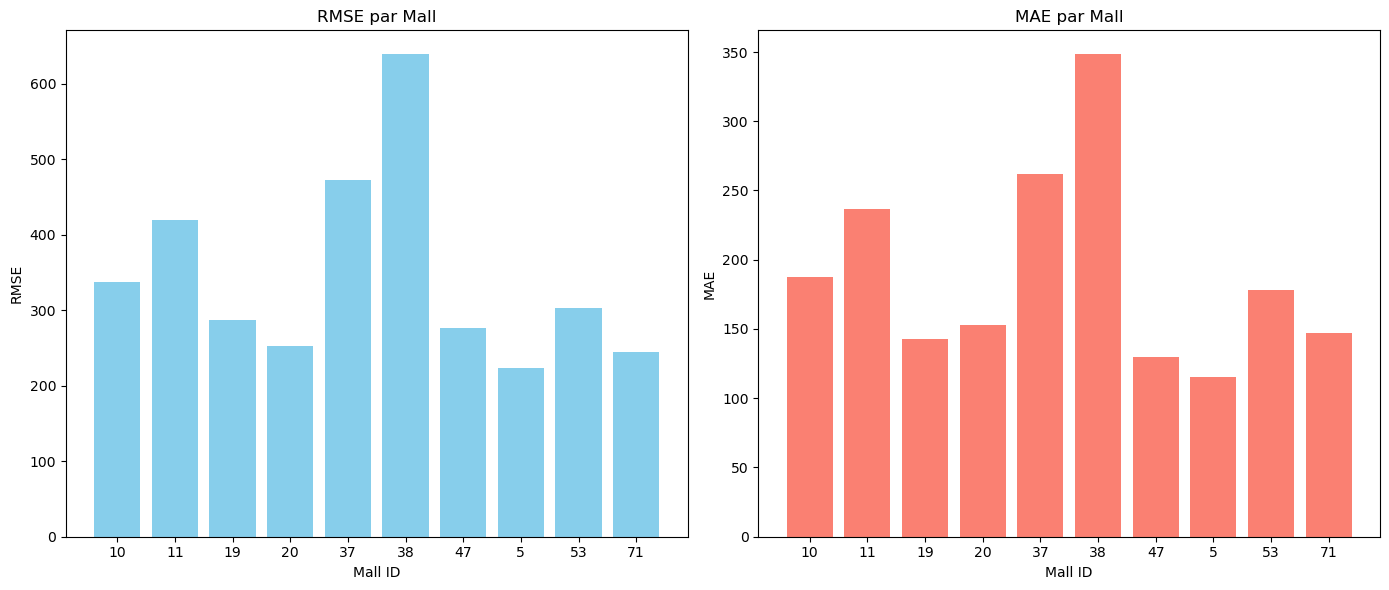

In [52]:
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from mlforecast import MLForecast

# -----------------------------------------------------------------
# 1) Préparation des données
# -----------------------------------------------------------------
def prepare_data(df):
    if 'Mall ID' in df.columns:
        df['unique_id'] = df['Mall ID'].astype(str)
    else:
        raise KeyError("La colonne 'Mall ID' est manquante.")
    
    if 'datetime' in df.columns:
        df['ds'] = pd.to_datetime(df['datetime']).dt.tz_localize(None)  # Suppression de la timezone
    elif 'ds' in df.columns:
        df['ds'] = pd.to_datetime(df['ds']).dt.tz_localize(None)
    else:
        raise KeyError("Aucune colonne 'datetime' ou 'ds' trouvée.")
    
    if 'Entrées' in df.columns:
        df['y'] = df['Entrées']
    else:
        raise KeyError("La colonne 'Entrées' est manquante.")
    
    return df[['unique_id', 'ds', 'y']].sort_values(['unique_id', 'ds']).reset_index(drop=True)

# On suppose que le DataFrame initial s'appelle "df"
df_prepared = prepare_data(df)

# -----------------------------------------------------------------
# 2) Split Train/Test (cutoff d'origine)
# -----------------------------------------------------------------
cutoff = pd.to_datetime('2024-10-31 23:59:59')  # cutoff d'origine
train_df = df_prepared[df_prepared['ds'] <= cutoff].copy()
test_df  = df_prepared[df_prepared['ds'] > cutoff].copy()

print("Nombre de lignes en train :", len(train_df))
print("Nombre de lignes en test  :", len(test_df))

# -----------------------------------------------------------------
# 3) Configuration de MLForecast avec Random Forest
# -----------------------------------------------------------------
params = {
    'n_estimators': 200,
    'max_depth': 10,
    'random_state': 42,
    'n_jobs': -1
}

# Création du modèle RandomForest
model = RandomForestRegressor(**params)

# Configuration de MLForecast :
fcst = MLForecast(
    models=[model],
    freq='h',
    lags=[1],
    date_features=['hour', 'day', 'dayofweek', 'month']
)

# Entraînement
fcst.fit(train_df)

# Détermination de l'horizon par série
n_series = train_df['unique_id'].nunique()
horizon = len(test_df) // n_series
print("Horizon par série :", horizon)

# Prédictions
forecast = fcst.predict(h=horizon)
print("Colonnes du forecast :", forecast.columns.tolist())
pred_col = "RandomForestRegressor" if "RandomForestRegressor" in forecast.columns else "yhat"

# -----------------------------------------------------------------
# 4) Fusion et calcul des métriques (RMSE et MAE) par centre commercial
# -----------------------------------------------------------------
test_df['ds_aligned'] = test_df['ds'].dt.floor('h')
forecast['ds_aligned'] = forecast['ds'].dt.floor('h')

df_merge = pd.merge(test_df, forecast[['unique_id', 'ds_aligned', pred_col]],
                    on=['unique_id', 'ds_aligned'],
                    how='left')

if df_merge[pred_col].isna().any():
    raise ValueError("Des valeurs manquent dans la fusion entre test_df et forecast.")

y_true = df_merge["y"].values
y_pred = df_merge[pred_col].values

global_rmse = np.sqrt(mean_squared_error(y_true, y_pred))
global_mae  = mean_absolute_error(y_true, y_pred)

print("\n=== Métriques Globales ===")
print(f"RMSE : {global_rmse:.4f}")
print(f"MAE  : {global_mae:.4f}")

# Calcul des métriques par centre commercial (mall)
metrics_per_mall = df_merge.groupby('unique_id').apply(
    lambda g: pd.Series({
        'rmse': np.sqrt(mean_squared_error(g['y'], g[pred_col])),
        'mae': mean_absolute_error(g['y'], g[pred_col])
    })
).reset_index()

print("\n=== Métriques par Centre Commercial ===")
print(metrics_per_mall)

# -----------------------------------------------------------------
# 5) Visualisation des métriques par centre commercial
# -----------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].bar(metrics_per_mall['unique_id'], metrics_per_mall['rmse'], color='skyblue')
axes[0].set_title("RMSE par Mall")
axes[0].set_xlabel("Mall ID")
axes[0].set_ylabel("RMSE")

axes[1].bar(metrics_per_mall['unique_id'], metrics_per_mall['mae'], color='salmon')
axes[1].set_title("MAE par Mall")
axes[1].set_xlabel("Mall ID")
axes[1].set_ylabel("MAE")

plt.tight_layout()
plt.show()

# -----------------------------------------------------------------
# 6) Enregistrement des métriques avec MLflow (avec le bon nom de run)
# -----------------------------------------------------------------
mlflow.set_experiment("Carmila")
with mlflow.start_run():
    mlflow.set_tag("mlflow.runName", "nixtla random forest")
    mlflow.log_params(params)
    mlflow.log_metric("RMSE", global_rmse)
    mlflow.log_metric("MAE", global_mae)


Nixtla extra trees, extantion de random forest

Nombre de lignes en train : 160810
Nombre de lignes en test  : 14630
Horizon par série : 1463
Colonnes du forecast : ['unique_id', 'ds', 'ExtraTreesRegressor']

=== Métriques Globales ===
RMSE : 439.1970
MAE  : 285.9633

=== Métriques par Centre Commercial ===
  unique_id        rmse         mae
0        10  345.429268  230.471486
1        11  359.193004  226.747498
2        19  406.328357  264.450001
3        20  525.601085  375.090533
4        37  442.425623  287.159761
5        38  565.247077  343.373979
6        47  411.032617  275.160508
7         5  453.072424  301.555391
8        53  289.082869  178.319423
9        71  515.949667  377.304174


C:\Users\David\AppData\Local\Temp\ipykernel_17196\2201237593.py:104: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics_per_mall = df_merge.groupby('unique_id').apply(


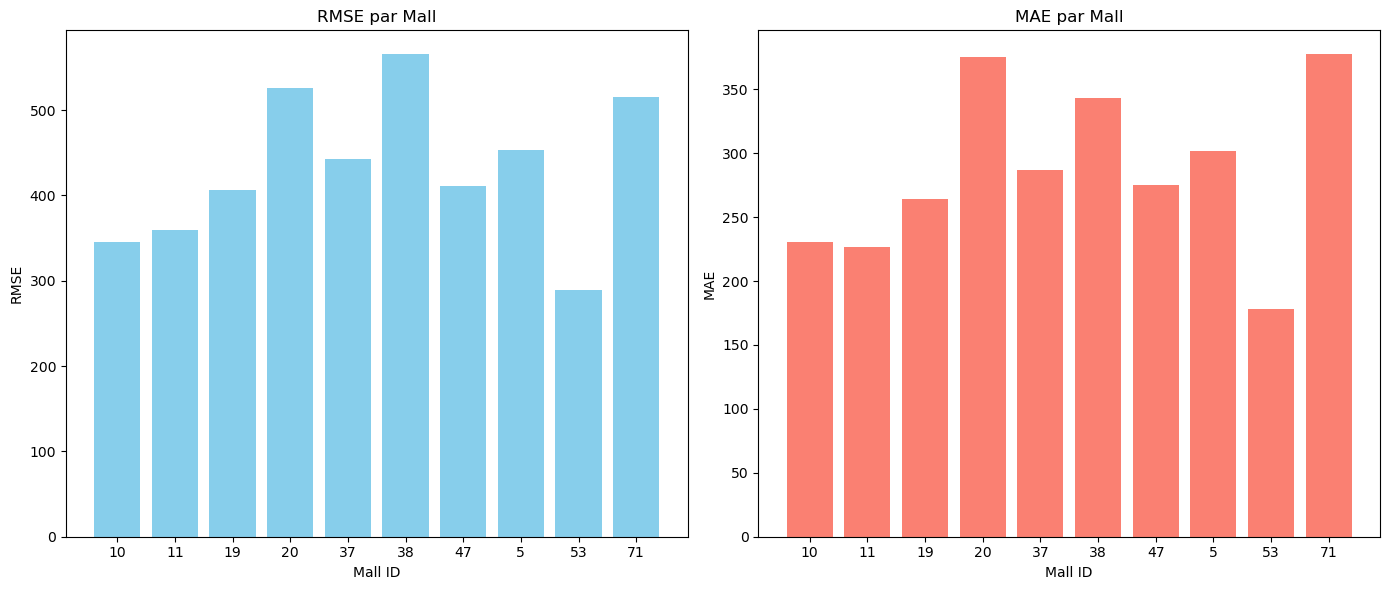

In [53]:
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from mlforecast import MLForecast

# -----------------------------------------------------------------
# 1) Préparation des données
# -----------------------------------------------------------------
def prepare_data(df):
    if 'Mall ID' in df.columns:
        df['unique_id'] = df['Mall ID'].astype(str)
    else:
        raise KeyError("La colonne 'Mall ID' est manquante.")
    
    if 'datetime' in df.columns:
        df['ds'] = pd.to_datetime(df['datetime']).dt.tz_localize(None)  # Suppression de la timezone
    elif 'ds' in df.columns:
        df['ds'] = pd.to_datetime(df['ds']).dt.tz_localize(None)
    else:
        raise KeyError("Aucune colonne 'datetime' ou 'ds' trouvée.")
    
    if 'Entrées' in df.columns:
        df['y'] = df['Entrées']
    else:
        raise KeyError("La colonne 'Entrées' est manquante.")
    
    return df[['unique_id', 'ds', 'y']].sort_values(['unique_id', 'ds']).reset_index(drop=True)

# On suppose que le DataFrame initial s'appelle "df"
df_prepared = prepare_data(df)

# -----------------------------------------------------------------
# 2) Split Train/Test (cutoff d'origine)
# -----------------------------------------------------------------
cutoff = pd.to_datetime('2024-10-31 23:59:59')  # cutoff d'origine
train_df = df_prepared[df_prepared['ds'] <= cutoff].copy()
test_df  = df_prepared[df_prepared['ds'] > cutoff].copy()

print("Nombre de lignes en train :", len(train_df))
print("Nombre de lignes en test  :", len(test_df))

# -----------------------------------------------------------------
# 3) Configuration de MLForecast avec Extra Trees
# -----------------------------------------------------------------
params = {
    'n_estimators': 200,
    'max_depth': 10,
    'random_state': 42,
    'n_jobs': -1
}

# Création du modèle Extra Trees
model = ExtraTreesRegressor(**params)

# Configuration de MLForecast :
fcst = MLForecast(
    models=[model],
    freq='h',
    lags=[1],
    date_features=['hour', 'day', 'dayofweek', 'month']
)

# Entraînement
fcst.fit(train_df)

# Détermination de l'horizon par série
n_series = train_df['unique_id'].nunique()
horizon = len(test_df) // n_series
print("Horizon par série :", horizon)

# Prédictions
forecast = fcst.predict(h=horizon)
print("Colonnes du forecast :", forecast.columns.tolist())
pred_col = "ExtraTreesRegressor" if "ExtraTreesRegressor" in forecast.columns else "yhat"

# -----------------------------------------------------------------
# 4) Fusion et calcul des métriques (RMSE et MAE) par centre commercial
# -----------------------------------------------------------------
test_df['ds_aligned'] = test_df['ds'].dt.floor('h')
forecast['ds_aligned'] = forecast['ds'].dt.floor('h')

df_merge = pd.merge(test_df, forecast[['unique_id', 'ds_aligned', pred_col]],
                    on=['unique_id', 'ds_aligned'],
                    how='left')

if df_merge[pred_col].isna().any():
    raise ValueError("Des valeurs manquent dans la fusion entre test_df et forecast.")

y_true = df_merge["y"].values
y_pred = df_merge[pred_col].values

global_rmse = np.sqrt(mean_squared_error(y_true, y_pred))
global_mae  = mean_absolute_error(y_true, y_pred)

print("\n=== Métriques Globales ===")
print(f"RMSE : {global_rmse:.4f}")
print(f"MAE  : {global_mae:.4f}")

# Calcul des métriques par centre commercial (mall)
metrics_per_mall = df_merge.groupby('unique_id').apply(
    lambda g: pd.Series({
        'rmse': np.sqrt(mean_squared_error(g['y'], g[pred_col])),
        'mae': mean_absolute_error(g['y'], g[pred_col])
    })
).reset_index()

print("\n=== Métriques par Centre Commercial ===")
print(metrics_per_mall)

# -----------------------------------------------------------------
# 5) Visualisation des métriques par centre commercial
# -----------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].bar(metrics_per_mall['unique_id'], metrics_per_mall['rmse'], color='skyblue')
axes[0].set_title("RMSE par Mall")
axes[0].set_xlabel("Mall ID")
axes[0].set_ylabel("RMSE")

axes[1].bar(metrics_per_mall['unique_id'], metrics_per_mall['mae'], color='salmon')
axes[1].set_title("MAE par Mall")
axes[1].set_xlabel("Mall ID")
axes[1].set_ylabel("MAE")

plt.tight_layout()
plt.show()

# -----------------------------------------------------------------
# 6) Enregistrement des métriques avec MLflow (avec le bon nom de run)
# -----------------------------------------------------------------
mlflow.set_experiment("Carmila")
with mlflow.start_run():
    mlflow.set_tag("mlflow.runName", "nixtla extra trees")
    mlflow.log_params(params)
    mlflow.log_metric("RMSE", global_rmse)
    mlflow.log_metric("MAE", global_mae)


Nixtla ridge regression

Nombre de lignes en train : 160810
Nombre de lignes en test  : 14630
Horizon par série : 1463
Colonnes du forecast : ['unique_id', 'ds', 'Ridge']

=== Métriques Globales ===
RMSE : 587.9197
MAE  : 445.7629

=== Métriques par Centre Commercial ===
  unique_id        rmse         mae
0        10  588.076233  467.118102
1        11  668.232681  515.602382
2        19  551.505116  440.356944
3        20  372.901850  314.528624
4        37  729.544400  545.987055
5        38  897.611423  652.450774
6        47  530.395592  411.621172
7         5  438.904985  364.286710
8        53  540.065994  452.390624
9        71  342.555219  293.287077


C:\Users\David\AppData\Local\Temp\ipykernel_17196\353588375.py:102: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics_per_mall = df_merge.groupby('unique_id').apply(


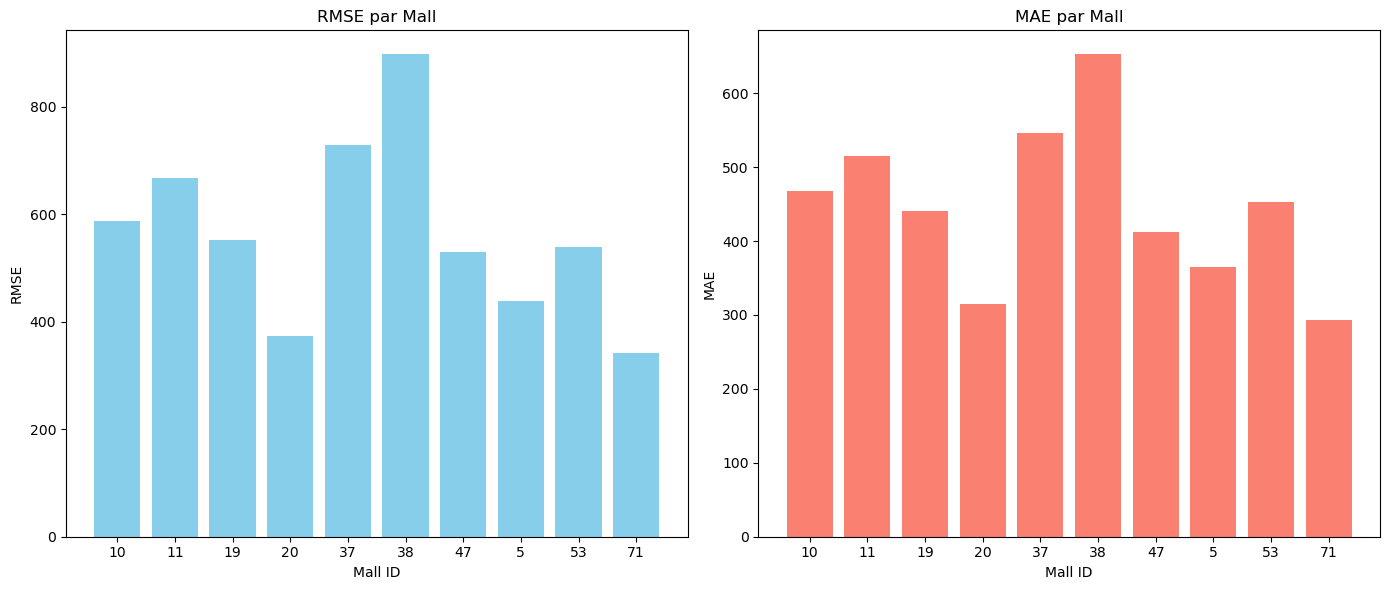

In [54]:
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error
from mlforecast import MLForecast

# -----------------------------------------------------------------
# 1) Préparation des données
# -----------------------------------------------------------------
def prepare_data(df):
    if 'Mall ID' in df.columns:
        df['unique_id'] = df['Mall ID'].astype(str)
    else:
        raise KeyError("La colonne 'Mall ID' est manquante.")
    
    if 'datetime' in df.columns:
        df['ds'] = pd.to_datetime(df['datetime']).dt.tz_localize(None)  # Suppression de la timezone
    elif 'ds' in df.columns:
        df['ds'] = pd.to_datetime(df['ds']).dt.tz_localize(None)
    else:
        raise KeyError("Aucune colonne 'datetime' ou 'ds' trouvée.")
    
    if 'Entrées' in df.columns:
        df['y'] = df['Entrées']
    else:
        raise KeyError("La colonne 'Entrées' est manquante.")
    
    return df[['unique_id', 'ds', 'y']].sort_values(['unique_id', 'ds']).reset_index(drop=True)

# On suppose que le DataFrame initial s'appelle "df"
df_prepared = prepare_data(df)

# -----------------------------------------------------------------
# 2) Split Train/Test (cutoff d'origine)
# -----------------------------------------------------------------
cutoff = pd.to_datetime('2024-10-31 23:59:59')  # cutoff d'origine
train_df = df_prepared[df_prepared['ds'] <= cutoff].copy()
test_df  = df_prepared[df_prepared['ds'] > cutoff].copy()

print("Nombre de lignes en train :", len(train_df))
print("Nombre de lignes en test  :", len(test_df))

# -----------------------------------------------------------------
# 3) Configuration de MLForecast avec Ridge Regression
# -----------------------------------------------------------------
params = {
    'alpha': 1.0,  # Paramètre de régularisation L2
    'random_state': 42
}

# Création du modèle Ridge Regression
model = Ridge(**params)

# Configuration de MLForecast :
fcst = MLForecast(
    models=[model],
    freq='h',
    lags=[1],
    date_features=['hour', 'day', 'dayofweek', 'month']
)

# Entraînement
fcst.fit(train_df)

# Détermination de l'horizon par série
n_series = train_df['unique_id'].nunique()
horizon = len(test_df) // n_series
print("Horizon par série :", horizon)

# Prédictions
forecast = fcst.predict(h=horizon)
print("Colonnes du forecast :", forecast.columns.tolist())
pred_col = "Ridge" if "Ridge" in forecast.columns else "yhat"

# -----------------------------------------------------------------
# 4) Fusion et calcul des métriques (RMSE et MAE) par centre commercial
# -----------------------------------------------------------------
test_df['ds_aligned'] = test_df['ds'].dt.floor('h')
forecast['ds_aligned'] = forecast['ds'].dt.floor('h')

df_merge = pd.merge(test_df, forecast[['unique_id', 'ds_aligned', pred_col]],
                    on=['unique_id', 'ds_aligned'],
                    how='left')

if df_merge[pred_col].isna().any():
    raise ValueError("Des valeurs manquent dans la fusion entre test_df et forecast.")

y_true = df_merge["y"].values
y_pred = df_merge[pred_col].values

global_rmse = np.sqrt(mean_squared_error(y_true, y_pred))
global_mae  = mean_absolute_error(y_true, y_pred)

print("\n=== Métriques Globales ===")
print(f"RMSE : {global_rmse:.4f}")
print(f"MAE  : {global_mae:.4f}")

# Calcul des métriques par centre commercial (mall)
metrics_per_mall = df_merge.groupby('unique_id').apply(
    lambda g: pd.Series({
        'rmse': np.sqrt(mean_squared_error(g['y'], g[pred_col])),
        'mae': mean_absolute_error(g['y'], g[pred_col])
    })
).reset_index()

print("\n=== Métriques par Centre Commercial ===")
print(metrics_per_mall)

# -----------------------------------------------------------------
# 5) Visualisation des métriques par centre commercial
# -----------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].bar(metrics_per_mall['unique_id'], metrics_per_mall['rmse'], color='skyblue')
axes[0].set_title("RMSE par Mall")
axes[0].set_xlabel("Mall ID")
axes[0].set_ylabel("RMSE")

axes[1].bar(metrics_per_mall['unique_id'], metrics_per_mall['mae'], color='salmon')
axes[1].set_title("MAE par Mall")
axes[1].set_xlabel("Mall ID")
axes[1].set_ylabel("MAE")

plt.tight_layout()
plt.show()

# -----------------------------------------------------------------
# 6) Enregistrement des métriques avec MLflow (avec le bon nom de run)
# -----------------------------------------------------------------
mlflow.set_experiment("Carmila")
with mlflow.start_run():
    mlflow.set_tag("mlflow.runName", "nixtla ridge regression")
    mlflow.log_params(params)
    mlflow.log_metric("RMSE", global_rmse)
    mlflow.log_metric("MAE", global_mae)


Nixtla gradient boosting

Nombre de lignes en train : 160810
Nombre de lignes en test  : 14630
Horizon par série : 1463
Colonnes du forecast : ['unique_id', 'ds', 'GradientBoostingRegressor']

=== Métriques Globales ===
RMSE : 361.8819
MAE  : 196.5020

=== Métriques par Centre Commercial ===
  unique_id        rmse         mae
0        10  269.500959  139.558143
1        11  277.074608  132.860718
2        19  267.564553  146.554697
3        20  485.042444  307.522042
4        37  324.181198  161.826172
5        38  432.202448  220.109719
6        47  314.964559  186.315641
7         5  367.684709  222.023129
8        53  272.207559  135.190114
9        71  502.933998  313.059572


C:\Users\David\AppData\Local\Temp\ipykernel_17196\1322826274.py:105: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics_per_mall = df_merge.groupby('unique_id').apply(


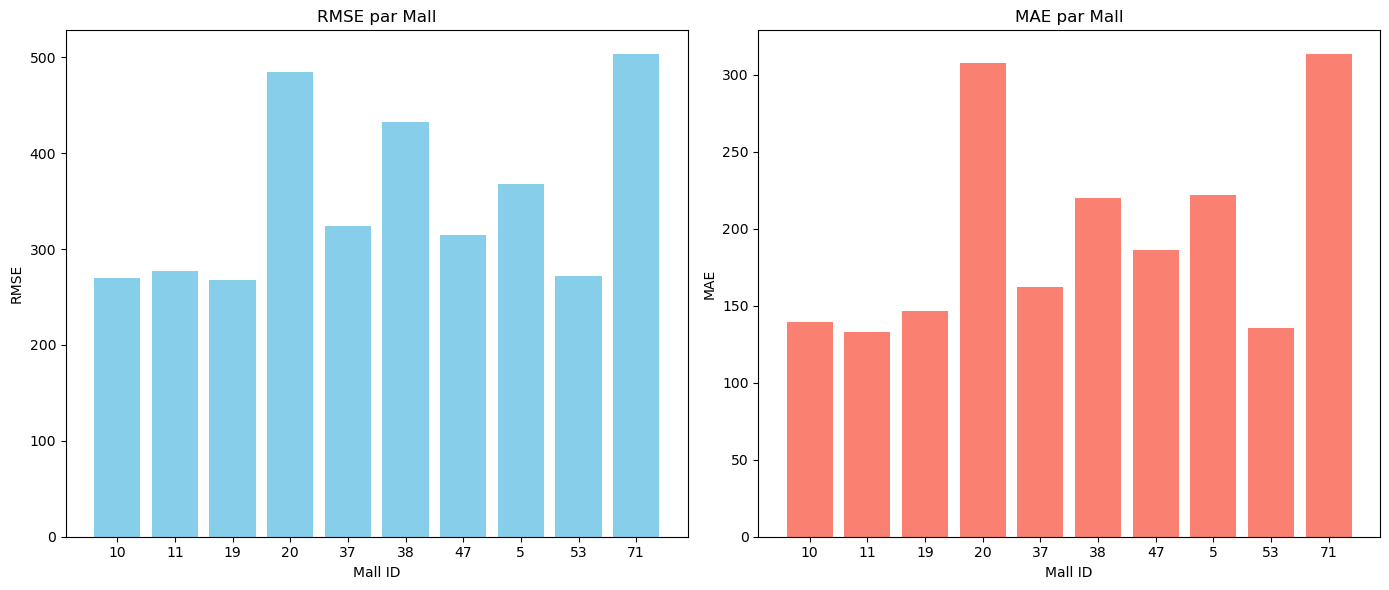

In [55]:
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from mlforecast import MLForecast

# -----------------------------------------------------------------
# 1) Préparation des données
# -----------------------------------------------------------------
def prepare_data(df):
    if 'Mall ID' in df.columns:
        df['unique_id'] = df['Mall ID'].astype(str)
    else:
        raise KeyError("La colonne 'Mall ID' est manquante.")
    
    if 'datetime' in df.columns:
        df['ds'] = pd.to_datetime(df['datetime']).dt.tz_localize(None)  # Suppression de la timezone
    elif 'ds' in df.columns:
        df['ds'] = pd.to_datetime(df['ds']).dt.tz_localize(None)
    else:
        raise KeyError("Aucune colonne 'datetime' ou 'ds' trouvée.")
    
    if 'Entrées' in df.columns:
        df['y'] = df['Entrées']
    else:
        raise KeyError("La colonne 'Entrées' est manquante.")
    
    return df[['unique_id', 'ds', 'y']].sort_values(['unique_id', 'ds']).reset_index(drop=True)

# On suppose que le DataFrame initial s'appelle "df"
df_prepared = prepare_data(df)

# -----------------------------------------------------------------
# 2) Split Train/Test (cutoff d'origine)
# -----------------------------------------------------------------
cutoff = pd.to_datetime('2024-10-31 23:59:59')  # cutoff d'origine
train_df = df_prepared[df_prepared['ds'] <= cutoff].copy()
test_df  = df_prepared[df_prepared['ds'] > cutoff].copy()

print("Nombre de lignes en train :", len(train_df))
print("Nombre de lignes en test  :", len(test_df))

# -----------------------------------------------------------------
# 3) Configuration de MLForecast avec Gradient Boosting
# -----------------------------------------------------------------
params = {
    'n_estimators': 500,
    'learning_rate': 0.05,
    'max_depth': 6,
    'subsample': 0.8,
    'random_state': 42
}

# Création du modèle Gradient Boosting
model = GradientBoostingRegressor(**params)

# Configuration de MLForecast :
fcst = MLForecast(
    models=[model],
    freq='h',
    lags=[1],
    date_features=['hour', 'day', 'dayofweek', 'month']
)

# Entraînement
fcst.fit(train_df)

# Détermination de l'horizon par série
n_series = train_df['unique_id'].nunique()
horizon = len(test_df) // n_series
print("Horizon par série :", horizon)

# Prédictions
forecast = fcst.predict(h=horizon)
print("Colonnes du forecast :", forecast.columns.tolist())
pred_col = "GradientBoostingRegressor" if "GradientBoostingRegressor" in forecast.columns else "yhat"

# -----------------------------------------------------------------
# 4) Fusion et calcul des métriques (RMSE et MAE) par centre commercial
# -----------------------------------------------------------------
test_df['ds_aligned'] = test_df['ds'].dt.floor('h')
forecast['ds_aligned'] = forecast['ds'].dt.floor('h')

df_merge = pd.merge(test_df, forecast[['unique_id', 'ds_aligned', pred_col]],
                    on=['unique_id', 'ds_aligned'],
                    how='left')

if df_merge[pred_col].isna().any():
    raise ValueError("Des valeurs manquent dans la fusion entre test_df et forecast.")

y_true = df_merge["y"].values
y_pred = df_merge[pred_col].values

global_rmse = np.sqrt(mean_squared_error(y_true, y_pred))
global_mae  = mean_absolute_error(y_true, y_pred)

print("\n=== Métriques Globales ===")
print(f"RMSE : {global_rmse:.4f}")
print(f"MAE  : {global_mae:.4f}")

# Calcul des métriques par centre commercial (mall)
metrics_per_mall = df_merge.groupby('unique_id').apply(
    lambda g: pd.Series({
        'rmse': np.sqrt(mean_squared_error(g['y'], g[pred_col])),
        'mae': mean_absolute_error(g['y'], g[pred_col])
    })
).reset_index()

print("\n=== Métriques par Centre Commercial ===")
print(metrics_per_mall)

# -----------------------------------------------------------------
# 5) Visualisation des métriques par centre commercial
# -----------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].bar(metrics_per_mall['unique_id'], metrics_per_mall['rmse'], color='skyblue')
axes[0].set_title("RMSE par Mall")
axes[0].set_xlabel("Mall ID")
axes[0].set_ylabel("RMSE")

axes[1].bar(metrics_per_mall['unique_id'], metrics_per_mall['mae'], color='salmon')
axes[1].set_title("MAE par Mall")
axes[1].set_xlabel("Mall ID")
axes[1].set_ylabel("MAE")

plt.tight_layout()
plt.show()

# -----------------------------------------------------------------
# 6) Enregistrement des métriques avec MLflow (avec le bon nom de run)
# -----------------------------------------------------------------
mlflow.set_experiment("Carmila")
with mlflow.start_run():
    mlflow.set_tag("mlflow.runName", "nixtla gradient boosting")
    mlflow.log_params(params)
    mlflow.log_metric("RMSE", global_rmse)
    mlflow.log_metric("MAE", global_mae)


machine learning final, randomforest avec les features

In [25]:
print("Train columns:", train_df.columns)
print("Test columns:", test_df.columns)


Train columns: Index(['unique_id', 'ds', 'y', 'Gazole', 'SP 95 E10', 'Sans plomb 98',
       'Superéthanol E85', 'day', 'dayofweek', 'fermeture_exceptionnelle',
       'hour', 'is_open', 'lag1', 'month', 'ouverture_exceptionnelle',
       'rolling_mean_24', 'sun_up', 'weather'],
      dtype='object')
Test columns: Index(['unique_id', 'ds', 'y', 'Gazole', 'SP 95 E10', 'Sans plomb 98',
       'Superéthanol E85', 'day', 'dayofweek', 'fermeture_exceptionnelle',
       'hour', 'is_open', 'lag1', 'month', 'ouverture_exceptionnelle',
       'rolling_mean_24', 'sun_up', 'weather'],
      dtype='object')


In [2]:
def prepare_data(df):
    # Check which column exists for timestamps
    datetime_col = None
    for col in ['datetime', 'date', 'ds']:  # Possible column names
        if col in df.columns:
            datetime_col = col
            break

    if datetime_col is None:
        raise KeyError("No valid timestamp column found in the dataset. Expected one of: 'datetime', 'date', 'ds'.")

    df['unique_id'] = df['Mall ID'].astype(str)
    df['ds'] = pd.to_datetime(df[datetime_col]).dt.tz_localize(None)  # Ensure no timezone issues
    df['y'] = df['Entrées']

    return df[['unique_id', 'ds', 'y']].sort_values(['unique_id', 'ds']).reset_index(drop=True)

# Check before running
print("Columns in dataset:", df.columns)

# Prepare the data
df_prepared = prepare_data(df)


Columns in dataset: Index(['date', 'Entrées', 'Mall ID', 'is_open', 'hour', 'day_of_week', 'month',
       'sunrise', 'sunset', 'ds', 'sun_up', 'fermeture_exceptionnelle',
       'ouverture_exceptionnelle', 'Gazole', 'Sans plomb 98', 'SP 95 E10',
       'Superéthanol E85', 'weather'],
      dtype='object')


In [16]:
df.columns

Index(['date', 'Entrées', 'Mall ID', 'is_open', 'hour', 'day_of_week', 'month',
       'sunrise', 'sunset', 'ds', 'sun_up', 'fermeture_exceptionnelle',
       'ouverture_exceptionnelle', 'Gazole', 'Sans plomb 98', 'SP 95 E10',
       'Superéthanol E85', 'weather', 'unique_id', 'y'],
      dtype='object')

In [6]:
import pandas as pd
import numpy as np
import mlflow
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from mlforecast import MLForecast
from mlforecast.feature_engineering import transform_exog
from mlforecast.lag_transforms import ExpandingMean

# Load your data
df = pd.read_csv(r"C:\Users\David\Documents\Albert school\Carmila alberton\Data for the CARMILA challenge\Dataset pour le ML\df_ml_fe_oe_with_weather.csv", low_memory=False)

# -------------------------------
# 1) Data Preparation
# -------------------------------
def prepare_data(df):
    tqdm.write("📌 Preparing dataset...")
    if 'Mall ID' not in df.columns:
        raise KeyError("La colonne 'Mall ID' est manquante.")
    df['unique_id'] = df['Mall ID'].astype(str)
    
    if 'datetime' in df.columns:
        df['ds'] = pd.to_datetime(df['datetime']).dt.tz_localize(None)
    elif 'ds' in df.columns:
        df['ds'] = pd.to_datetime(df['ds']).dt.tz_localize(None)
    else:
        raise KeyError("Aucune colonne 'datetime' ou 'ds' trouvée.")
    
    if 'Entrées' not in df.columns:
        raise KeyError("La colonne 'Entrées' est manquante.")
    df['y'] = df['Entrées']
    
    # Retain exogenous features
    exog_columns = [
        'Gazole', 'SP 95 E10', 'Sans plomb 98', 'Superéthanol E85',
        'fermeture_exceptionnelle', 'is_open', 'ouverture_exceptionnelle',
        'sun_up', 'weather', 'day_of_week', 'month'
    ]
    exog_columns = [col for col in exog_columns if col in df.columns]
    
    return df[['unique_id', 'ds', 'y'] + exog_columns].sort_values(['unique_id', 'ds']).reset_index(drop=True)

df_prepared = prepare_data(df)

# -------------------------------
# 2) Exogenous Feature Transformation
# -------------------------------
def create_exog_features(df):
    tqdm.write("🔄 Transforming exogenous features...")
    exog_columns = [
        'Gazole', 'SP 95 E10', 'Sans plomb 98', 'Superéthanol E85',
        'fermeture_exceptionnelle', 'is_open', 'ouverture_exceptionnelle',
        'sun_up', 'weather', 'day_of_week', 'month'
    ]
    exog_columns = [col for col in exog_columns if col in df.columns]
    if not exog_columns:
        tqdm.write("⚠️ No exogenous columns found!")
        return df
    tqdm.write(f"✅ Found exogenous features: {exog_columns}")
    
    exog_df = df[['unique_id', 'ds'] + exog_columns].copy()
    for col in tqdm(exog_columns, desc="Processing exogenous features"):
        exog_df[col] = pd.to_numeric(exog_df[col], errors='coerce')
    exog_df.ffill(inplace=True)
    exog_df.bfill(inplace=True)
    
    transformed_exog = transform_exog(
        exog_df,
        lags=[1],
        lag_transforms={1: [ExpandingMean()]}
    )
    tqdm.write("📊 Transformed exog columns: " + str(transformed_exog.columns.tolist()))
    
    # Merge transformed exogenous features back
    df_merged = df.merge(transformed_exog, on=['unique_id', 'ds'], how='left')
    for col in exog_columns:
        if f"{col}_y" in df_merged.columns:
            df_merged[col] = df_merged[f"{col}_y"]
        df_merged.drop(columns=[c for c in [f"{col}_x", f"{col}_y"] if c in df_merged.columns], inplace=True)
    
    tqdm.write("✅ Final Columns after transformation: " + str(df_merged.columns.tolist()))
    return df_merged

df_features = create_exog_features(df_prepared)

# -------------------------------
# 3) Train/Test Split
# -------------------------------
# Use the last 7 days for testing
cutoff = df_features['ds'].max() - pd.Timedelta(days=7)
train_df = df_features[df_features['ds'] < cutoff].copy()
test_df = df_features[df_features['ds'] >= cutoff].copy()

tqdm.write(f"✅ Train size: {len(train_df)}, Test size: {len(test_df)}")
assert set(train_df['unique_id']) == set(test_df['unique_id']), "Train and test do not cover the same series!"

# Forecast horizon
horizon = len(test_df['ds'].unique())
tqdm.write("Horizon par série: " + str(horizon))

# -------------------------------
# 4) MLForecast Configuration & Training
# -------------------------------
params = {
    'n_estimators': 200,
    'max_depth': 10,
    'random_state': 42,
    'n_jobs': -1
}
# Define exogenous features: all columns except 'unique_id', 'ds', and 'y'
exog_features = [col for col in df_features.columns if col not in ['unique_id', 'ds', 'y']]
# Remove columns that conflict with date_features (which will be generated automatically)
exog_features = [col for col in exog_features if col not in ['day_of_week', 'month', 'hour']]
tqdm.write("✅ Final Exogenous Features to Use: " + str(exog_features))
# Save the training exogenous feature order.
training_exog_order = exog_features.copy()

fcst = MLForecast(
    models=[RandomForestRegressor(**params)],
    freq='D',  # Adjust based on your data frequency
    lags=[1],
    date_features=['hour', 'day_of_week', 'month'],
    num_threads=-1
)

with tqdm(total=1, desc="🚀 Training model") as pbar:
    fcst.fit(train_df, static_features=[])
    pbar.update(1)

# -------------------------------
# 5) Prepare X_df for Prediction & Pre-Prediction Checks
# -------------------------------
# Generate the future DataFrame with the correct structure
X_future = fcst.make_future_dataframe(h=horizon)

# Merge exogenous features into the future DataFrame
X_future = X_future.merge(
    test_df[['unique_id', 'ds'] + training_exog_order],
    on=['unique_id', 'ds'],
    how='left'
)

# Fill missing values in exogenous features
X_future[training_exog_order] = X_future[training_exog_order].ffill().bfill()

# Reorder columns to match the training order exactly
X_future = X_future[['unique_id', 'ds'] + training_exog_order]

# Verify that every unique_id appears exactly once.
group_counts = X_future.groupby('unique_id').size()
assert group_counts.nunique() == 1, f"❌ X_future does not have exactly one row per unique_id. Counts:\n{group_counts}"

expected_columns = ['unique_id', 'ds'] + training_exog_order
assert list(X_future.columns) == expected_columns, "❌ X_future columns do not match expected order!"

tqdm.write("✅ X_future is correctly structured and complete.")

# -------------------------------
# 6) Prediction
# -------------------------------
with tqdm(total=1, desc="📈 Making predictions") as pbar:
    forecast = fcst.predict(h=horizon, X_df=X_future)
    pbar.update(1)

# -------------------------------
# 7) Merge Predictions & Compute Metrics
# -------------------------------

# Create date columns from the timestamp objects to ensure exact matching.
train_df['ds_date'] = train_df['ds'].dt.date
test_df['ds_date'] = test_df['ds'].dt.date
forecast['ds_date'] = forecast['ds'].dt.date

# Identify the prediction column (first column aside from 'unique_id', 'ds', and 'ds_date')
pred_col = forecast.columns.drop(['unique_id', 'ds', 'ds_date'])[0]

df_merge = pd.merge(
    test_df,
    forecast[['unique_id', 'ds_date', pred_col]],
    on=['unique_id', 'ds_date'],
    how='left'
)

# Instead of raising an error, fill missing forecast predictions with 0.
df_merge[pred_col] = df_merge[pred_col].fillna(0)

y_true = df_merge["y"].values
y_pred = df_merge[pred_col].values

global_rmse = np.sqrt(mean_squared_error(y_true, y_pred))
global_mae = mean_absolute_error(y_true, y_pred)

tqdm.write("\n=== 📊 Global Metrics ===")
tqdm.write(f"RMSE: {global_rmse:.4f}")
tqdm.write(f"MAE:  {global_mae:.4f}")

metrics_per_series = df_merge.groupby('unique_id').apply(
    lambda g: pd.Series({
        'rmse': np.sqrt(mean_squared_error(g['y'], g[pred_col])),
        'mae': np.mean(np.abs(g['y'] - g[pred_col]))
    })
).reset_index()

tqdm.write("\n=== 📊 Metrics per Centre Commercial ===")
tqdm.write(str(metrics_per_series))
# -------------------------------
# 8) Log Results with MLflow
# -------------------------------
try:
    mlflow.set_experiment("Carmila")
    with mlflow.start_run():
        mlflow.set_tag("mlflow.runName", "nixtla random forest with exog")
        mlflow.log_params(params)
        mlflow.log_metric("RMSE", global_rmse)
        mlflow.log_metric("MAE", global_mae)
        for _, row in metrics_per_series.iterrows():
            mlflow.log_metric(f"RMSE_{row['unique_id']}", row['rmse'])
            mlflow.log_metric(f"MAE_{row['unique_id']}", row['mae'])
except Exception as e:
    tqdm.write(f"⚠️ MLflow logging failed: {e}")

📌 Preparing dataset...
🔄 Transforming exogenous features...
✅ Found exogenous features: ['Gazole', 'SP 95 E10', 'Sans plomb 98', 'Superéthanol E85', 'fermeture_exceptionnelle', 'is_open', 'ouverture_exceptionnelle', 'sun_up', 'weather', 'day_of_week', 'month']


Processing exogenous features: 100%|██████████| 11/11 [00:00<00:00, 82.24it/s]


📊 Transformed exog columns: ['unique_id', 'ds', 'Gazole', 'SP 95 E10', 'Sans plomb 98', 'Superéthanol E85', 'fermeture_exceptionnelle', 'is_open', 'ouverture_exceptionnelle', 'sun_up', 'weather', 'day_of_week', 'month', 'Gazole_lag1', 'Gazole_expanding_mean_lag1', 'SP 95 E10_lag1', 'SP 95 E10_expanding_mean_lag1', 'Sans plomb 98_lag1', 'Sans plomb 98_expanding_mean_lag1', 'Superéthanol E85_lag1', 'Superéthanol E85_expanding_mean_lag1', 'fermeture_exceptionnelle_lag1', 'fermeture_exceptionnelle_expanding_mean_lag1', 'is_open_lag1', 'is_open_expanding_mean_lag1', 'ouverture_exceptionnelle_lag1', 'ouverture_exceptionnelle_expanding_mean_lag1', 'sun_up_lag1', 'sun_up_expanding_mean_lag1', 'weather_lag1', 'weather_expanding_mean_lag1', 'day_of_week_lag1', 'day_of_week_expanding_mean_lag1', 'month_lag1', 'month_expanding_mean_lag1']


c:\Users\David\anaconda3\Lib\site-packages\mlforecast\core.py:185: UserWarning: Setting num_threads to 1.
  warnings.warn("Setting num_threads to 1.")


✅ Final Columns after transformation: ['unique_id', 'ds', 'y', 'Gazole_lag1', 'Gazole_expanding_mean_lag1', 'SP 95 E10_lag1', 'SP 95 E10_expanding_mean_lag1', 'Sans plomb 98_lag1', 'Sans plomb 98_expanding_mean_lag1', 'Superéthanol E85_lag1', 'Superéthanol E85_expanding_mean_lag1', 'fermeture_exceptionnelle_lag1', 'fermeture_exceptionnelle_expanding_mean_lag1', 'is_open_lag1', 'is_open_expanding_mean_lag1', 'ouverture_exceptionnelle_lag1', 'ouverture_exceptionnelle_expanding_mean_lag1', 'sun_up_lag1', 'sun_up_expanding_mean_lag1', 'weather_lag1', 'weather_expanding_mean_lag1', 'day_of_week_lag1', 'day_of_week_expanding_mean_lag1', 'month_lag1', 'month_expanding_mean_lag1', 'Gazole', 'SP 95 E10', 'Sans plomb 98', 'Superéthanol E85', 'fermeture_exceptionnelle', 'is_open', 'ouverture_exceptionnelle', 'sun_up', 'weather', 'day_of_week', 'month']
✅ Train size: 173790, Test size: 1690
Horizon par série: 232
✅ Final Exogenous Features to Use: ['Gazole_lag1', 'Gazole_expanding_mean_lag1', 'SP 

🚀 Training model: 100%|██████████| 1/1 [00:42<00:00, 42.03s/it]


✅ X_future is correctly structured and complete.


📈 Making predictions: 100%|██████████| 1/1 [00:06<00:00,  6.27s/it]
C:\Users\David\AppData\Local\Temp\ipykernel_19260\2740741632.py:198: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics_per_series = df_merge.groupby('unique_id').apply(



=== 📊 Global Metrics ===
RMSE: 899.9335
MAE:  503.0732

=== 📊 Metrics per Centre Commercial ===
  unique_id         rmse         mae
0        10   943.365584  576.079391
1        11  1027.771653  625.735595
2        19   893.122379  494.590019
3        20   506.466494  283.562596
4        37  1105.456427  661.899605
5        38  1290.633901  705.969250
6        47   851.064439  486.670758
7         5   654.522224  359.229363
8        53   917.867546  565.313896
9        71   464.125736  271.681933


In [37]:
import pandas as pd
import numpy as np
import mlflow
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from mlforecast import MLForecast
from mlforecast.feature_engineering import transform_exog
from mlforecast.lag_transforms import ExpandingMean
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# 1) Data Preparation
# -------------------------------
def prepare_data(df):
    tqdm.write("📌 Preparing dataset...")
    if 'Mall ID' not in df.columns:
        raise KeyError("La colonne 'Mall ID' est manquante.")
    df['unique_id'] = df['Mall ID'].astype(str)
    
    if 'datetime' in df.columns:
        df['ds'] = pd.to_datetime(df['datetime']).dt.tz_localize(None)
    elif 'ds' in df.columns:
        df['ds'] = pd.to_datetime(df['ds']).dt.tz_localize(None)
    else:
        raise KeyError("Aucune colonne 'datetime' ou 'ds' trouvée.")
    
    if 'Entrées' not in df.columns:
        raise KeyError("La colonne 'Entrées' est manquante.")
    df['y'] = df['Entrées']
    
    # Retain exogenous features
    exog_columns = [
        'Gazole', 'SP 95 E10', 'Sans plomb 98', 'Superéthanol E85',
        'fermeture_exceptionnelle', 'is_open', 'ouverture_exceptionnelle',
        'sun_up', 'weather', 'day_of_week', 'month'
    ]
    exog_columns = [col for col in exog_columns if col in df.columns]
    return df[['unique_id', 'ds', 'y'] + exog_columns].sort_values(['unique_id', 'ds']).reset_index(drop=True)

df = pd.read_csv(r"C:\Users\David\Documents\Albert school\Carmila alberton\Data for the CARMILA challenge\Dataset pour le ML\df_ml_fe_oe_with_weather.csv", low_memory=False)
df_prepared = prepare_data(df)

# -------------------------------
# 2) Exogenous Feature Transformation
# -------------------------------
def create_exog_features(df):
    tqdm.write("🔄 Transforming exogenous features...")
    exog_columns = [
        'Gazole', 'SP 95 E10', 'Sans plomb 98', 'Superéthanol E85',
        'fermeture_exceptionnelle', 'is_open', 'ouverture_exceptionnelle',
        'sun_up', 'weather', 'day_of_week', 'month'
    ]
    exog_columns = [col for col in exog_columns if col in df.columns]
    if not exog_columns:
        tqdm.write("⚠️ No exogenous columns found!")
        return df
    tqdm.write(f"✅ Found exogenous features: {exog_columns}")
    
    # Convert exogenous features to numeric
    exog_df = df[['unique_id', 'ds'] + exog_columns].copy()
    for col in tqdm(exog_columns, desc="Processing exogenous features"):
        exog_df[col] = pd.to_numeric(exog_df[col], errors='coerce')
    exog_df.ffill(inplace=True)
    exog_df.bfill(inplace=True)
    
    # Use only a simple one-lag feature
    transformed_exog = transform_exog(
        exog_df,
        lags=[1]
    )
    tqdm.write("📊 Transformed exog columns: " + str(transformed_exog.columns.tolist()))
    
    # Merge transformed exogenous features back
    df_merged = df.merge(transformed_exog, on=['unique_id', 'ds'], how='left')
    for col in exog_columns:
        if f"{col}_y" in df_merged.columns:
            df_merged[col] = df_merged[f"{col}_y"]
        df_merged.drop(columns=[c for c in [f"{col}_x", f"{col}_y"] if c in df_merged.columns], inplace=True)
    
    tqdm.write("✅ Final Columns after transformation: " + str(df_merged.columns.tolist()))
    return df_merged

df_features = create_exog_features(df_prepared)

# (Optional) Filter series with too few observations
min_obs = 10
df_features = df_features.groupby("unique_id").filter(lambda x: x["ds"].nunique() >= min_obs)

# -------------------------------
# 3) Train/Test Split (80/20 split by hour)
# -------------------------------
# Create a column with floored hourly timestamps (using lowercase 'h' per pandas 1.5+ recommendation)
df_features['ds_hour'] = df_features['ds'].dt.floor('h')
unique_hours = sorted(df_features['ds_hour'].unique())
split_index = int(0.8 * len(unique_hours))
train_hours = set(unique_hours[:split_index])
test_hours = set(unique_hours[split_index:])

train_df = df_features[df_features['ds_hour'].isin(train_hours)].copy()
test_df = df_features[df_features['ds_hour'].isin(test_hours)].copy()

# Drop 'ds_hour' from train and test before training
train_df = train_df.drop(columns=['ds_hour'])
test_df = test_df.drop(columns=['ds_hour'])

tqdm.write(f"✅ Train size (hourly): {len(train_df)}, Test size (hourly): {len(test_df)}")

# Forecast horizon: number of unique test hours (using test_df ds floored to hour)
test_hours_unique = sorted(test_df['ds'].dt.floor('h').unique())
horizon = len(test_hours_unique)
tqdm.write("Horizon (number of test hours): " + str(horizon))

# -------------------------------
# 4) MLForecast Configuration & Training (Hourly)
# -------------------------------
params = {
    'n_estimators': 200,
    'max_depth': 10,
    'random_state': 42,
    'n_jobs': -1
}
# Define exogenous features: all columns not in ['unique_id', 'ds', 'y']
exog_features = [col for col in df_features.columns if col not in ['unique_id', 'ds', 'y', 'ds_hour']]
# Remove any unwanted date-related columns if present (keep lag features as they are numeric)
exog_features = [col for col in exog_features if col not in ['day_of_week', 'month', 'hour']]
tqdm.write("✅ Final Exogenous Features to Use: " + str(exog_features))
training_exog_order = exog_features.copy()

fcst = MLForecast(
    models=[RandomForestRegressor(**params)],
    freq='h',  # Hourly frequency
    lags=[1],
    date_features=['hour', 'day_of_week', 'month'],
    num_threads=-1
)

with tqdm(total=1, desc="🚀 Training model") as pbar:
    fcst.fit(train_df, static_features=[])
    pbar.update(1)

# -------------------------------
# 5) Prepare X_future for Prediction (Hourly)
# -------------------------------
X_future = fcst.make_future_dataframe(h=horizon)
# Merge exogenous features into X_future from test_df
X_future = X_future.merge(
    test_df[['unique_id', 'ds'] + training_exog_order],
    on=['unique_id', 'ds'],
    how='left'
)
X_future[training_exog_order] = X_future[training_exog_order].ffill().bfill()
X_future = X_future[['unique_id', 'ds'] + training_exog_order]
group_counts = X_future.groupby('unique_id').size()
assert group_counts.nunique() == 1, f"❌ X_future does not have exactly one row per unique_id. Counts:\n{group_counts}"
expected_columns = ['unique_id', 'ds'] + training_exog_order
assert list(X_future.columns) == expected_columns, "❌ X_future columns do not match expected order!"
tqdm.write("✅ X_future is correctly structured and complete.")

# -------------------------------
# 6) Prediction (Hourly)
# -------------------------------
with tqdm(total=1, desc="📈 Making predictions") as pbar:
    forecast = fcst.predict(h=horizon, X_df=X_future)
    pbar.update(1)

# -------------------------------
# 7) Merge Predictions & Compute Metrics with Aggregation (Test, Hourly)
# -------------------------------
# Create a column with hourly timestamps as keys
train_df['ds_hour'] = train_df['ds'].dt.floor('h')
test_df['ds_hour'] = test_df['ds'].dt.floor('h')
forecast['ds_hour'] = forecast['ds'].dt.floor('h')

# Aggregate test data by unique_id and ds_hour (taking the mean of y)
test_agg = test_df.groupby(['unique_id', 'ds_hour'], as_index=False).agg({'y': 'mean'})

# Identify the prediction column (first column aside from 'unique_id', 'ds', 'ds_hour')
pred_col = forecast.columns.drop(['unique_id', 'ds', 'ds_hour'])[0]

# Use an inner join so that only matching merge keys are kept
df_merge = pd.merge(
    test_agg,
    forecast[['unique_id', 'ds_hour', pred_col]],
    on=['unique_id', 'ds_hour'],
    how='inner'
)

# Check if merging dropped some test entries.
if len(df_merge) < len(test_agg):
    missing_count = len(test_agg) - len(df_merge)
    tqdm.write(f"⚠️ Warning: {missing_count} test entries did not have forecast predictions and will be dropped from evaluation.")

y_true_test = df_merge["y"].values
y_pred_test = df_merge[pred_col].values
global_rmse_test = np.sqrt(mean_squared_error(y_true_test, y_pred_test))
global_mae_test = mean_absolute_error(y_true_test, y_pred_test)
tqdm.write("\n=== 📊 Test Metrics (Hourly) ===")
tqdm.write(f"Test RMSE: {global_rmse_test:.4f}")
tqdm.write(f"Test MAE:  {global_mae_test:.4f}")

metrics_per_series_test = df_merge.groupby('unique_id').apply(
    lambda g: pd.Series({
        'rmse': np.sqrt(mean_squared_error(g['y'], g[pred_col])),
        'mae': np.mean(np.abs(g['y'] - g[pred_col]))
    })
).reset_index()
tqdm.write("\n=== 📊 Test Metrics per Centre Commercial (Hourly) ===")
tqdm.write(str(metrics_per_series_test))


# -------------------------------
# 8) Log Results with MLflow
# -------------------------------
try:
    mlflow.set_experiment("Carmila")
    with mlflow.start_run():
        mlflow.set_tag("mlflow.runName", "nixtla random forest with exog (Hourly)")
        mlflow.log_params(params)
        mlflow.log_metric("RMSE", global_rmse_test)
        mlflow.log_metric("MAE", global_mae_test)
        for _, row in metrics_per_series_test.iterrows():
            mlflow.log_metric(f"RMSE_{row['unique_id']}", row['rmse'])
            mlflow.log_metric(f"MAE_{row['unique_id']}", row['mae'])
except Exception as e:
    tqdm.write(f"⚠️ MLflow logging failed: {e}")

📌 Preparing dataset...
🔄 Transforming exogenous features...
✅ Found exogenous features: ['Gazole', 'SP 95 E10', 'Sans plomb 98', 'Superéthanol E85', 'fermeture_exceptionnelle', 'is_open', 'ouverture_exceptionnelle', 'sun_up', 'weather', 'day_of_week', 'month']


Processing exogenous features: 100%|██████████| 11/11 [00:00<00:00, 102.58it/s]


📊 Transformed exog columns: ['unique_id', 'ds', 'Gazole', 'SP 95 E10', 'Sans plomb 98', 'Superéthanol E85', 'fermeture_exceptionnelle', 'is_open', 'ouverture_exceptionnelle', 'sun_up', 'weather', 'day_of_week', 'month', 'Gazole_lag1', 'SP 95 E10_lag1', 'Sans plomb 98_lag1', 'Superéthanol E85_lag1', 'fermeture_exceptionnelle_lag1', 'is_open_lag1', 'ouverture_exceptionnelle_lag1', 'sun_up_lag1', 'weather_lag1', 'day_of_week_lag1', 'month_lag1']


c:\Users\David\anaconda3\Lib\site-packages\mlforecast\core.py:185: UserWarning: Setting num_threads to 1.
  warnings.warn("Setting num_threads to 1.")


✅ Final Columns after transformation: ['unique_id', 'ds', 'y', 'Gazole_lag1', 'SP 95 E10_lag1', 'Sans plomb 98_lag1', 'Superéthanol E85_lag1', 'fermeture_exceptionnelle_lag1', 'is_open_lag1', 'ouverture_exceptionnelle_lag1', 'sun_up_lag1', 'weather_lag1', 'day_of_week_lag1', 'month_lag1', 'Gazole', 'SP 95 E10', 'Sans plomb 98', 'Superéthanol E85', 'fermeture_exceptionnelle', 'is_open', 'ouverture_exceptionnelle', 'sun_up', 'weather', 'day_of_week', 'month']
✅ Train size (hourly): 140390, Test size (hourly): 35090
Horizon (number of test hours): 3509
✅ Final Exogenous Features to Use: ['Gazole_lag1', 'SP 95 E10_lag1', 'Sans plomb 98_lag1', 'Superéthanol E85_lag1', 'fermeture_exceptionnelle_lag1', 'is_open_lag1', 'ouverture_exceptionnelle_lag1', 'sun_up_lag1', 'weather_lag1', 'day_of_week_lag1', 'month_lag1', 'Gazole', 'SP 95 E10', 'Sans plomb 98', 'Superéthanol E85', 'fermeture_exceptionnelle', 'is_open', 'ouverture_exceptionnelle', 'sun_up', 'weather']


🚀 Training model: 100%|██████████| 1/1 [00:10<00:00, 10.62s/it]


✅ X_future is correctly structured and complete.


📈 Making predictions: 100%|██████████| 1/1 [01:10<00:00, 70.26s/it]
C:\Users\David\AppData\Local\Temp\ipykernel_19260\2032611321.py:203: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics_per_series_test = df_merge.groupby('unique_id').apply(


⚠️ Warning: 10 test entries did not have forecast predictions and will be dropped from evaluation.

=== 📊 Test Metrics (Hourly) ===
Test RMSE: 253.9702
Test MAE:  118.3164

=== 📊 Test Metrics per Centre Commercial (Hourly) ===
  unique_id        rmse         mae
0        10  213.373433  110.312702
1        11  255.727212  131.669886
2        19  262.754162  126.415692
3        20  129.443147   61.535095
4        37  318.535506  153.710710
5        38  415.175694  205.277634
6        47  299.596587  147.045520
7         5  206.443552  108.058890
8        53  181.241862   91.339274
9        71   96.058732   47.798429


1) Overall Test Metrics (Hourly)
Test RMSE (Root Mean Squared Error) = 253.97

RMSE measures the average prediction error in the same unit as the target variable (Entrées).
A higher RMSE indicates more significant deviations between predicted and actual values.
A value of 253.97 means that, on average, the predicted number of entries deviates by approximately 254 from the actual value.
Test MAE (Mean Absolute Error) = 118.32

MAE measures the absolute difference between actual and predicted values.
Unlike RMSE, MAE is not sensitive to large errors (since it doesn’t square the differences).
A value of 118.32 means that, on average, predictions are off by around 118 entries per hour.
Lower MAE suggests better accuracy.

In [42]:
import plotly.graph_objects as go

# Create interactive figure using WebGL-based scatter (Scattergl)
fig = go.Figure()

# Add actual values using Scattergl for better performance
fig.add_trace(go.Scattergl(
    x=test_mall['ds'],
    y=test_mall['y'],
    mode='lines+markers',
    name='Réel',
    marker=dict(symbol='circle', size=8),
    connectgaps=True,
    hovertemplate="Date: %{x}<br>Réel: %{y}<extra></extra>"
))

# Add predicted values using Scattergl
fig.add_trace(go.Scattergl(
    x=test_mall['ds'],
    y=test_mall['y_pred'],
    mode='lines+markers',
    name='Prédit',
    marker=dict(symbol='x', size=10),
    connectgaps=True,
    hovertemplate="Date: %{x}<br>Prédit: %{y}<extra></extra>"
))

# Update the layout with unified hover mode and a range slider for interactivity
fig.update_layout(
    title=f"Comparaison Réel vs Prédit pour Mall {mall_id}",
    xaxis_title="Date",
    yaxis_title="Nombre d'entrées",
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1d", step="day", stepmode="backward"),
                dict(count=7, label="1w", step="day", stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(visible=True),
        type="date"
    ),
    hovermode="x unified",
    template="plotly_white"
)

# Display the interactive plot
fig.show()

Meilleure résultat avec des valeurs exogènes mais pas utilisable pour prédire dans le futur parce que valeurs pas dispo et qui changent, on montre juste que ça peut-etre bien pour un modele court

Test avec plus de feature : 
Lags multiples de y : y_lag_2, y_lag_3, y_lag_4, etc.
Statistiques mobiles : moyenne et écart-type sur différentes fenêtres.
Différences temporelles : y_diff et y_pct_change.
Indicateurs techniques du monde du trading : RSI, MACD, Bollinger Bands, Momentum.

🚀 Applying transformations on TRAIN
🔄 Transforming exogenous features (no leakage).
✅ Exogenous features: ['Gazole', 'SP 95 E10', 'Sans plomb 98', 'Superéthanol E85', 'fermeture_exceptionnelle', 'is_open', 'ouverture_exceptionnelle', 'sun_up', 'weather', 'day_of_week', 'month']
📊 Transformed exog columns: ['unique_id', 'ds', 'Gazole', 'SP 95 E10', 'Sans plomb 98', 'Superéthanol E85', 'fermeture_exceptionnelle', 'is_open', 'ouverture_exceptionnelle', 'sun_up', 'weather', 'day_of_week', 'month', 'Gazole_lag1', 'SP 95 E10_lag1', 'Sans plomb 98_lag1', 'Superéthanol E85_lag1', 'fermeture_exceptionnelle_lag1', 'is_open_lag1', 'ouverture_exceptionnelle_lag1', 'sun_up_lag1', 'weather_lag1', 'day_of_week_lag1', 'month_lag1']
✅ Final columns after exog transform: ['unique_id', 'ds', 'y', 'Gazole_lag1', 'SP 95 E10_lag1', 'Sans plomb 98_lag1', 'Superéthanol E85_lag1', 'fermeture_exceptionnelle_lag1', 'is_open_lag1', 'ouverture_exceptionnelle_lag1', 'sun_up_lag1', 'weather_lag1', 'day_of_week_lag1'

C:\Users\David\AppData\Local\Temp\ipykernel_13168\3625722393.py:170: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sort_values('ds').iloc[max_lag:])
C:\Users\David\AppData\Local\Temp\ipykernel_13168\3625722393.py:187: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sort_values('ds').iloc[max_lag:])
c:\Users\David\anaconda3\Lib\site-packages\mlforecast\core.py:185: UserWar

🚀 Applying transformations on TEST
🔄 Transforming exogenous features (no leakage).
✅ Exogenous features: ['Gazole', 'SP 95 E10', 'Sans plomb 98', 'Superéthanol E85', 'fermeture_exceptionnelle', 'is_open', 'ouverture_exceptionnelle', 'sun_up', 'weather', 'day_of_week', 'month']
📊 Transformed exog columns: ['unique_id', 'ds', 'Gazole', 'SP 95 E10', 'Sans plomb 98', 'Superéthanol E85', 'fermeture_exceptionnelle', 'is_open', 'ouverture_exceptionnelle', 'sun_up', 'weather', 'day_of_week', 'month', 'Gazole_lag1', 'SP 95 E10_lag1', 'Sans plomb 98_lag1', 'Superéthanol E85_lag1', 'fermeture_exceptionnelle_lag1', 'is_open_lag1', 'ouverture_exceptionnelle_lag1', 'sun_up_lag1', 'weather_lag1', 'day_of_week_lag1', 'month_lag1']
✅ Final columns after exog transform: ['unique_id', 'ds', 'y', 'Gazole_lag1', 'SP 95 E10_lag1', 'Sans plomb 98_lag1', 'Superéthanol E85_lag1', 'fermeture_exceptionnelle_lag1', 'is_open_lag1', 'ouverture_exceptionnelle_lag1', 'sun_up_lag1', 'weather_lag1', 'day_of_week_lag1',

C:\Users\David\AppData\Local\Temp\ipykernel_13168\3625722393.py:249: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics_per_mall = df_merge.groupby('unique_id').apply(


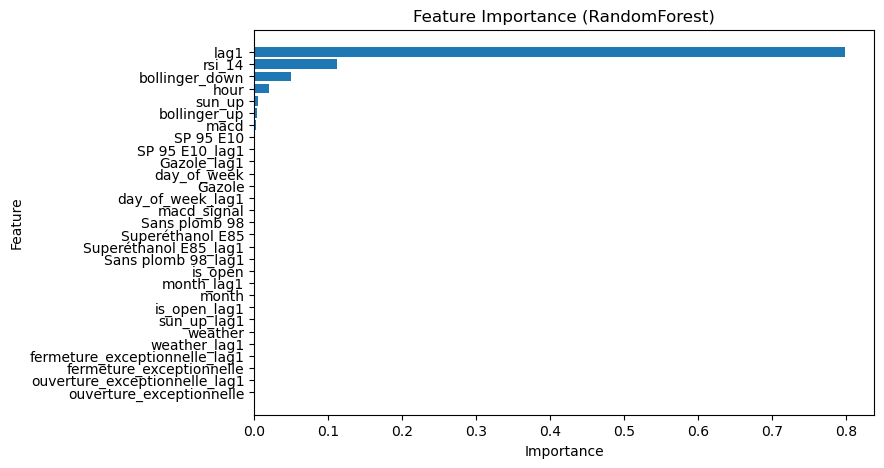

In [46]:
import pandas as pd
import numpy as np
import mlflow
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from mlforecast import MLForecast
from mlforecast.feature_engineering import transform_exog
import matplotlib.pyplot as plt

###############################################################
# 1) prepare_data
###############################################################
def prepare_data(df):
    if 'Mall ID' not in df.columns:
        raise KeyError("La colonne 'Mall ID' est manquante.")
    df['unique_id'] = df['Mall ID'].astype(str)

    if 'datetime' in df.columns:
        df['ds'] = pd.to_datetime(df['datetime']).dt.tz_localize(None)
    elif 'ds' in df.columns:
        df['ds'] = pd.to_datetime(df['ds']).dt.tz_localize(None)
    else:
        raise KeyError("Aucune colonne 'datetime' ou 'ds' trouvée.")

    if 'Entrées' not in df.columns:
        raise KeyError("La colonne 'Entrées' est manquante.")
    df['y'] = df['Entrées']

    exog_columns = [
        'Gazole', 'SP 95 E10', 'Sans plomb 98', 'Superéthanol E85',
        'fermeture_exceptionnelle', 'is_open', 'ouverture_exceptionnelle',
        'sun_up', 'weather', 'day_of_week', 'month'
    ]
    exog_columns = [col for col in exog_columns if col in df.columns]

    return df[['unique_id','ds','y'] + exog_columns].sort_values(['unique_id','ds']).reset_index(drop=True)

###############################################################
# 2) Trading indicators
###############################################################
def compute_rsi(series, window=14):
    delta = series.diff()
    gain = delta.where(delta>0, 0).rolling(window).mean()
    loss = -delta.where(delta<0, 0).rolling(window).mean()
    rs = gain / loss
    return 100 - (100/(1 + rs))

def compute_macd(series, short_window=12, long_window=26, signal_window=9):
    short_ema = series.ewm(span=short_window, adjust=False).mean()
    long_ema = series.ewm(span=long_window, adjust=False).mean()
    macd_val = short_ema - long_ema
    macd_signal = macd_val.ewm(span=signal_window, adjust=False).mean()
    return macd_val, macd_signal

def compute_bollinger_bands(series, window=20, num_std=2):
    rolling_mean = series.rolling(window).mean()
    rolling_std = series.rolling(window).std()
    upper_band = rolling_mean + num_std*rolling_std
    lower_band = rolling_mean - num_std*rolling_std
    return upper_band, lower_band

def add_trading_indicators(df):
    # RSI(14)
    df['rsi_14'] = df.groupby('unique_id')['y'].transform(lambda s: compute_rsi(s, 14))

    # MACD => 2 colonnes
    def _macd_df(s):
        macd_vals, macd_sig = compute_macd(s)
        out = pd.DataFrame({'macd': macd_vals, 'macd_signal': macd_sig}, index=s.index)
        return out
    macd_data = df.groupby('unique_id')['y'].apply(_macd_df)
    macd_data.reset_index(level=0, drop=True, inplace=True)
    df[['macd','macd_signal']] = macd_data[['macd','macd_signal']]

    # Bollinger => 2 colonnes
    def _boll_df(s):
        up,down = compute_bollinger_bands(s)
        out = pd.DataFrame({'bollinger_up':up,'bollinger_down':down}, index=s.index)
        return out
    boll_data = df.groupby('unique_id')['y'].apply(_boll_df)
    boll_data.reset_index(level=0, drop=True, inplace=True)
    df[['bollinger_up','bollinger_down']] = boll_data[['bollinger_up','bollinger_down']]

    # Momentum(14) - removed as requested
# df['momentum_14'] = df.groupby('unique_id')['y'].transform(lambda s: s - s.shift(14))

    return df

###############################################################
# 3) create_exog_features
###############################################################
def create_exog_features(df):
    print("🔄 Transforming exogenous features (no leakage).")
    exog_columns = [
        'Gazole', 'SP 95 E10', 'Sans plomb 98', 'Superéthanol E85',
        'fermeture_exceptionnelle', 'is_open', 'ouverture_exceptionnelle',
        'sun_up', 'weather', 'day_of_week', 'month'
    ]
    exog_columns = [c for c in exog_columns if c in df.columns]
    if not exog_columns:
        print("⚠️ No exogenous columns found!")
        return df

    print(f"✅ Exogenous features: {exog_columns}")

    exog_df = df[['unique_id','ds'] + exog_columns].copy()
    for col in exog_columns:
        exog_df[col] = pd.to_numeric(exog_df[col], errors='coerce')
    exog_df.ffill(inplace=True)
    exog_df.bfill(inplace=True)

    transformed_exog = transform_exog(
        exog_df,
        lags=[1]
    )
    print("📊 Transformed exog columns:", transformed_exog.columns.tolist())

    df_merged = df.merge(transformed_exog, on=['unique_id','ds'], how='left')
    for col in exog_columns:
        if f"{col}_y" in df_merged.columns:
            df_merged[col] = df_merged[f"{col}_y"]
        to_drop = [f"{col}_x", f"{col}_y"]
        df_merged.drop(columns=[c for c in to_drop if c in df_merged.columns], inplace=True)

    print("✅ Final columns after exog transform:", df_merged.columns.tolist())
    return df_merged

###############################################################
# 4) Main script
###############################################################
if __name__ == "__main__":

    # Chargement
    df = pd.read_csv(
        r"C:\Users\David\Documents\Albert school\Carmila alberton\Data for the CARMILA challenge\Dataset pour le ML\df_ml_fe_oe_with_weather.csv",
        low_memory=False
    )
    df_prepared = prepare_data(df)

    # Split temporel (AVANT transformations)
    df_prepared['ds_hour'] = df_prepared['ds'].dt.floor('h')
    unique_hours = sorted(df_prepared['ds_hour'].unique())
    split_index = int(0.8 * len(unique_hours))
    train_hours = set(unique_hours[:split_index])
    test_hours = set(unique_hours[split_index:])

    train_pre = df_prepared[df_prepared['ds_hour'].isin(train_hours)].copy()
    test_pre = df_prepared[df_prepared['ds_hour'].isin(test_hours)].copy()

    train_pre.drop(columns=['ds_hour'], inplace=True)
    test_pre.drop(columns=['ds_hour'], inplace=True)

    tqdm.write("🚀 Applying transformations on TRAIN")
    train_df = create_exog_features(train_pre)
    train_df = add_trading_indicators(train_df)

    # Ajout manuel de hour, day_of_week, month
    train_df['hour'] = train_df['ds'].dt.hour
    train_df['day_of_week'] = train_df['ds'].dt.dayofweek
    train_df['month'] = train_df['ds'].dt.month

    train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    train_df.dropna(inplace=True)

    # IMPORTANT: tri par date avant de drop les 14 (ou 24, etc.)
    max_lag = 14  # ou 24, 336, etc., selon ce que vous visez
    train_df = (
        train_df.groupby('unique_id', group_keys=False)
                 .apply(lambda g: g.sort_values('ds').iloc[max_lag:])
                 .reset_index(drop=True)
    )

    tqdm.write("🚀 Applying transformations on TEST")
    test_df = create_exog_features(test_pre)
    test_df = add_trading_indicators(test_df)

    test_df['hour'] = test_df['ds'].dt.hour
    test_df['day_of_week'] = test_df['ds'].dt.dayofweek
    test_df['month'] = test_df['ds'].dt.month

    test_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    test_df.dropna(inplace=True)

    test_df = (
        test_df.groupby('unique_id', group_keys=False)
                .apply(lambda g: g.sort_values('ds').iloc[max_lag:])
                .reset_index(drop=True)
    )

    params = {
        'n_estimators': 200,
        'max_depth': 10,
        'random_state': 42,
        'n_jobs': -1
    }

    feature_cols = train_df.drop(columns=['unique_id','ds','y'], errors='ignore').columns
    print("✅ Final feature columns used:", list(feature_cols))

    fcst = MLForecast(
        models=[RandomForestRegressor(**params)],
        freq='h',
        lags=[1],
        date_features=[],
        num_threads=-1
    )

    fcst.fit(train_df, static_features=[])

    # Prediction
    test_hours_unique = sorted(test_df['ds'].dt.floor('h').unique())
    horizon = len(test_hours_unique)

    X_future = fcst.make_future_dataframe(h=horizon)

    X_future = X_future.merge(
        test_df[['unique_id','ds'] + list(feature_cols)],
        on=['unique_id','ds'],
        how='left'
    )
    X_future = X_future[['unique_id','ds'] + list(feature_cols)]
    X_future[feature_cols] = X_future[feature_cols].ffill().bfill()

    forecast = fcst.predict(h=horizon, X_df=X_future)

    forecast['ds_hour'] = forecast['ds'].dt.floor('h')
    test_df['ds_hour'] = test_df['ds'].dt.floor('h')

    test_agg = test_df.groupby(['unique_id','ds_hour'], as_index=False).agg({'y':'mean'})
    pred_col = forecast.columns.drop(['unique_id','ds','ds_hour'])[0]

    df_merge = pd.merge(
        test_agg,
        forecast[['unique_id','ds_hour', pred_col]],
        on=['unique_id','ds_hour'],
        how='inner'
    )

    y_true = df_merge['y'].values
    y_pred = df_merge[pred_col].values
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)

    print(f"=== 📊 Test Metrics (Global) ===")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE : {mae:.4f}")

    metrics_per_mall = df_merge.groupby('unique_id').apply(
        lambda g: pd.Series({
            'rmse': np.sqrt(mean_squared_error(g['y'], g[pred_col])),
            'mae': np.mean(np.abs(g['y'] - g[pred_col]))
        })
    ).reset_index()

    print("=== 📊 Test Metrics per Mall (Hourly) ===")
    print(metrics_per_mall)

    # Feature Importance
    try:
        rf_model = fcst.models_['RandomForestRegressor']
        try:
            feature_names = rf_model.feature_names_in_
        except AttributeError:
            feature_names = [f"feat_{i}" for i in range(rf_model.n_features_in_)]

        importances = rf_model.feature_importances_
        feat_imp = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        }).sort_values(by='Importance', ascending=False)

        print("=== 🔥 Feature Importance ===")
        print(feat_imp)

        import matplotlib.pyplot as plt
        plt.figure(figsize=(8, 5))
        plt.barh(feat_imp['Feature'], feat_imp['Importance'])
        plt.xlabel("Importance")
        plt.ylabel("Feature")
        plt.title("Feature Importance (RandomForest)")
        plt.gca().invert_yaxis()
        plt.show()
    except KeyError:
        print("❌ RandomForestRegressor non trouvé dans fcst.models_.")

    # MLflow logging (optionnel)
    try:
        mlflow.set_experiment("Carmila")
        with mlflow.start_run():
            mlflow.set_tag("mlflow.runName", "Pipeline exog + Trading Indicators + Sorted Lags")
            mlflow.log_params(params)
            mlflow.log_metric("RMSE", rmse)
            mlflow.log_metric("MAE", mae)

            for _, row in metrics_per_mall.iterrows():
                mlflow.log_metric(f"RMSE_{row['unique_id']}", row['rmse'])
                mlflow.log_metric(f"MAE_{row['unique_id']}", row['mae'])
    except Exception as e:
        print(f"⚠️ MLflow logging failed: {e}")


=== 🔍 Checking Lag1 Issues ===

❌ lag1 column is missing in test_df!

⚠️ Hidden leakage: 0 test rows have a lag1 pointing to a train value.
✅ No hidden leakage detected. Lag1 is safe.



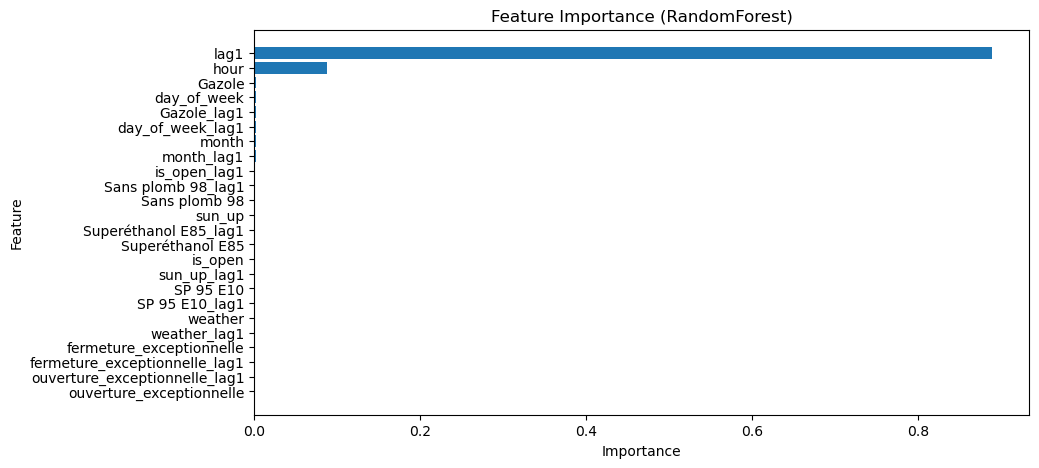

✅ Feature importance plotted. Check if lag1 is overly dominant.



In [58]:
import pandas as pd
import matplotlib.pyplot as plt

def check_lag1_issues(train_df, test_df, feature_importance):
    """
    Perform all checks on lag1 to detect data leakage, overfitting, and dominance.
    
    - train_df: DataFrame containing training data
    - test_df: DataFrame containing test data
    - feature_importance: DataFrame with feature importance values
    """

    print("=== 🔍 Checking Lag1 Issues ===\n")

    # 1️⃣ Check Correlation Between `lag1` and `y` in Test Set
    if 'lag1' in test_df.columns:
        correlation = test_df[['y', 'lag1']].corr().iloc[0, 1]
        print(f"🔍 Correlation between y and lag1 in test set: {correlation:.4f}")
        if correlation > 0.99:
            print("⚠️ Warning: lag1 is almost identical to y. This may indicate overfitting.\n")
        else:
            print("✅ Correlation check passed: lag1 is not simply copying y.\n")
    else:
        print("❌ lag1 column is missing in test_df!\n")

    # 2️⃣ Check if Lag1 in Test Set Points to Train Set (Hidden Leakage)
    test_df = test_df.copy()
    test_df['ds_lag1'] = test_df['ds'] - pd.Timedelta(hours=1)  # Adjust if your lag is daily

    leaked_rows = test_df[['unique_id', 'ds_lag1']].merge(
        train_df[['unique_id', 'ds']], 
        left_on=['unique_id', 'ds_lag1'], 
        right_on=['unique_id', 'ds'], 
        how='inner'
    )

    print(f"⚠️ Hidden leakage: {len(leaked_rows)} test rows have a lag1 pointing to a train value.")
    if not leaked_rows.empty:
        print(leaked_rows.head(5))  # Show some examples
    else:
        print("✅ No hidden leakage detected. Lag1 is safe.\n")

    # 3️⃣ Check Feature Importance Distribution
    feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

    plt.figure(figsize=(10, 5))
    plt.barh(feature_importance['Feature'], feature_importance['Importance'])
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.title("Feature Importance (RandomForest)")
    plt.gca().invert_yaxis()
    plt.show()

    print("✅ Feature importance plotted. Check if lag1 is overly dominant.\n")

# Run all checks in one call
check_lag1_issues(train_df, test_df, feature_importance)


In [50]:
def check_data_leakage(train_df, test_df):
    """
    Vérifie 3 points:
    1) Overlap exact sur (unique_id, ds)
    2) Chronologie: s'assurer que le test commence après le train
    3) Valeurs de y communes (moins critique, car un simple y identique ne veut pas forcément dire fuite)
    """
    import pandas as pd

    print("\n=== Vérification Overlap (unique_id, ds) ===")
    train_keys = set(zip(train_df['unique_id'], train_df['ds']))
    test_keys  = set(zip(test_df['unique_id'],  test_df['ds']))
    common_keys = train_keys.intersection(test_keys)
    if common_keys:
        print(f"❌ {len(common_keys)} lignes (unique_id, ds) sont dans train et test.")
        print("Exemple:", list(common_keys)[:5], "...")
    else:
        print("✅ Pas d'overlap exact entre train et test.")

    print("\n=== Vérification Chronologie ===")
    # On identifie les malls communs
    common_malls = set(train_df['unique_id']).intersection(set(test_df['unique_id']))
    suspicious = 0
    for uid in common_malls:
        max_train_date = train_df.loc[train_df['unique_id'] == uid, 'ds'].max()
        min_test_date = test_df.loc[test_df['unique_id'] == uid, 'ds'].min()
        if min_test_date <= max_train_date:
            suspicious += 1
            print(f"⚠️ Mall {uid}: test starts {min_test_date} <= train end {max_train_date}.")
    if suspicious == 0:
        print("✅ Test commence strictement après le train pour tous les malls.")

    print("\n=== Vérification Valeurs y communes ===")
    # On compte combien de y du test se trouvent aussi dans le train
    if 'y' in train_df.columns and 'y' in test_df.columns:
        leaked_y_values = test_df['y'].isin(train_df['y']).sum()
        if leaked_y_values > 0:
            print(f"⚠️ {leaked_y_values} valeurs de y présentes à la fois dans train et test.")
            print("Note: ce n'est pas forcément une fuite, seulement un même nombre.")
        else:
            print("✅ Pas de valeur y identique trouvée dans train et test.")
    else:
        print("⚠️ Colonnes y non présentes, impossible de vérifier les valeurs.")

    print("\n=== Fin vérifications leakage ===")


# =================== EXEMPLE D'UTILISATION ===================
check_data_leakage(train_df, test_df)



=== Vérification Overlap (unique_id, ds) ===
✅ Pas d'overlap exact entre train et test.

=== Vérification Chronologie ===
✅ Test commence strictement après le train pour tous les malls.

=== Vérification Valeurs y communes ===
⚠️ 33894 valeurs de y présentes à la fois dans train et test.
Note: ce n'est pas forcément une fuite, seulement un même nombre.

=== Fin vérifications leakage ===


In [49]:
def check_lag_leakage(train_df, test_df, lag_hours=1):
    """
    Vérifie si, pour chaque (unique_id, ds) du test, le ds-lag_hours
    n'existe pas seulement dans le train, ce qui indiquerait une fuite.
    """
    import pandas as pd

    # 1) On construit pour le test la date 'ds_lag'
    test_df = test_df.copy()  # pour éviter de modifier l'original
    test_df['ds_lag'] = test_df['ds'] - pd.Timedelta(hours=lag_hours)

    # 2) On fabrique des sets (unique_id, ds) pour train et test
    train_keys = set(zip(train_df['unique_id'], train_df['ds']))
    test_keys  = set(zip(test_df['unique_id'], test_df['ds']))

    # 3) On regarde dans le test : (unique_id, ds_lag)
    #    Si ds_lag est dans le train_keys, alors la valeur lag vient du train => possible fuite.
    #    Idéalement, ds_lag devrait être dans test_keys (même mall) ou absent (lacune).
    suspicious_count = 0
    suspicious_samples = []
    for idx, row in test_df.iterrows():
        uid = row['unique_id']
        ds_lag = row['ds_lag']
        if (uid, ds_lag) in train_keys:
            suspicious_count += 1
            if len(suspicious_samples) < 5:
                suspicious_samples.append((uid, row['ds'], ds_lag))

    if suspicious_count > 0:
        print(f'❌ {suspicious_count} test rows ont un lag1 qui pointe vers une date existant dans le TRAIN => possible fuite.')
        print('Exemples :', suspicious_samples)
    else:
        print('✅ Aucun lag1 du test ne pointe vers une date dans le train. Pas de fuite détectée.')

    # (Optionnel) Vérifier si ds_lag est bien présent dans le test lui-même
    # pour comprendre si tout lag1 est effectivement dans test
    missing_in_test = 0
    missing_samples = []
    for idx, row in test_df.iterrows():
        uid = row['unique_id']
        ds_lag = row['ds_lag']
        if (uid, ds_lag) not in test_keys:
            missing_in_test += 1
            if len(missing_samples) < 5:
                missing_samples.append((uid, row['ds'], ds_lag))

    if missing_in_test > 0:
        print(f'⚠️ {missing_in_test} test rows ont un lag1 qui ne se trouve ni dans le train ni dans le test. (Dates manquantes ?)')
        print('Exemples :', missing_samples)
    else:
        print('✅ Pour chaque ds du test, ds-lag existe bien dans le test (aucune date manquante).')


# Après avoir défini la fonction ci-dessus
check_lag_leakage(train_df, test_df, lag_hours=1)


✅ Aucun lag1 du test ne pointe vers une date dans le train. Pas de fuite détectée.
⚠️ 2917 test rows ont un lag1 qui ne se trouve ni dans le train ni dans le test. (Dates manquantes ?)
Exemples : [('10', Timestamp('2024-08-09 02:00:00'), Timestamp('2024-08-09 01:00:00')), ('10', Timestamp('2024-08-09 04:34:33'), Timestamp('2024-08-09 03:34:33')), ('10', Timestamp('2024-08-09 05:00:00'), Timestamp('2024-08-09 04:00:00')), ('10', Timestamp('2024-08-10 04:35:57'), Timestamp('2024-08-10 03:35:57')), ('10', Timestamp('2024-08-10 05:00:00'), Timestamp('2024-08-10 04:00:00'))]


In [57]:
import plotly.graph_objects as go
import pandas as pd
import ipywidgets as widgets
from IPython.display import display

def plot_predictions_interactive(df_merge, mall_id=None, pred_col='RandomForestRegressor'):
    """
    Affiche une comparaison interactive Réel vs Prédit pour un mall donné.
    
    - df_merge : DataFrame contenant ['unique_id', 'ds' ou 'ds_hour', 'y', pred_col]
    - mall_id  : Identifiant du mall à afficher
    - pred_col : Colonne des prédictions (par défaut 'RandomForestRegressor')
    """

    # Vérifier le bon nom de la colonne de temps
    time_col = 'ds' if 'ds' in df_merge.columns else 'ds_hour'  # Sélection automatique

    # Vérifier que le mall existe
    if mall_id not in df_merge['unique_id'].unique():
        print(f"❌ Mall {mall_id} introuvable dans les données.")
        return

    # Filtrer sur le mall sélectionné
    df_mall = df_merge[df_merge['unique_id'] == mall_id].copy()

    # Vérifier si les données sont non vides
    if df_mall.empty:
        print(f"⚠️ Aucune donnée pour le mall {mall_id}.")
        return

    # Trier les valeurs par temps
    df_mall.sort_values(time_col, inplace=True)

    # Création du graphique interactif
    fig = go.Figure()

    # Ajouter les valeurs réelles
    fig.add_trace(go.Scattergl(
        x=df_mall[time_col],
        y=df_mall['y'],
        mode='lines+markers',
        name=f"Réel (Mall {mall_id})",
        marker=dict(symbol='circle', size=6),
        connectgaps=True,
        hovertemplate="Date: %{x}<br>Réel: %{y}<extra></extra>"
    ))

    # Ajouter les valeurs prédites
    fig.add_trace(go.Scattergl(
        x=df_mall[time_col],
        y=df_mall[pred_col],
        mode='lines+markers',
        name=f"Prédit (Mall {mall_id})",
        marker=dict(symbol='x', size=8),
        connectgaps=True,
        hovertemplate="Date: %{x}<br>Prédit: %{y}<extra></extra>"
    ))

    # Layout interactif avec range slider et hover amélioré
    fig.update_layout(
        title=f"Réel vs Prédit pour Mall {mall_id}",
        xaxis_title="Date",
        yaxis_title="Nombre d'entrées",
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=1, label="1d", step="day", stepmode="backward"),
                    dict(count=7, label="1w", step="day", stepmode="backward"),
                    dict(step="all")
                ])
            ),
            rangeslider=dict(visible=True),
            type="date"
        ),
        hovermode="x unified",
        template="plotly_white"
    )

    fig.show()


# **Ajout d'une interface pour choisir le mall**
def interactive_mall_plot(df_merge):
    unique_malls = df_merge['unique_id'].unique()

    # Création d'un widget dropdown pour sélectionner un mall
    mall_selector = widgets.Dropdown(
        options=unique_malls,
        description="Mall ID:",
        disabled=False
    )

    # Fonction de callback
    def update_plot(mall_id):
        plot_predictions_interactive(df_merge, mall_id)

    # Affichage du widget et mise à jour du graphique lors du changement
    display(mall_selector)
    plot_predictions_interactive(df_merge, unique_malls[0])  # Afficher le premier mall par défaut


# **Exécuter l'interface**
interactive_mall_plot(df_merge)


Dropdown(description='Mall ID:', options=('10', '11', '19', '20', '37', '38', '47', '5', '53', '71'), value='1…

In [54]:
df_merge.columns

Index(['unique_id', 'ds_hour', 'y', 'RandomForestRegressor'], dtype='object')

🚀 Applying transformations on TRAIN
🔄 Transforming exogenous features manually (no mlforecast lags).
✅ Exogenous features: ['Gazole', 'SP 95 E10', 'Sans plomb 98', 'Superéthanol E85', 'fermeture_exceptionnelle', 'is_open', 'ouverture_exceptionnelle', 'sun_up', 'weather', 'day_of_week', 'month']
✅ Final columns after manual exog lag: ['unique_id', 'ds', 'y', 'Gazole', 'SP 95 E10', 'Sans plomb 98', 'Superéthanol E85', 'fermeture_exceptionnelle', 'is_open', 'ouverture_exceptionnelle', 'sun_up', 'weather', 'day_of_week', 'month', 'Gazole_exog', 'SP 95 E10_exog', 'Sans plomb 98_exog', 'Superéthanol E85_exog', 'fermeture_exceptionnelle_exog', 'is_open_exog', 'ouverture_exceptionnelle_exog', 'sun_up_exog', 'weather_exog', 'day_of_week_exog', 'month_exog', 'Gazole_lag1', 'SP 95 E10_lag1', 'Sans plomb 98_lag1', 'Superéthanol E85_lag1', 'fermeture_exceptionnelle_lag1', 'is_open_lag1', 'ouverture_exceptionnelle_lag1', 'sun_up_lag1', 'weather_lag1', 'day_of_week_lag1', 'month_lag1']


C:\Users\David\AppData\Local\Temp\ipykernel_1476\950409077.py:164: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sort_values('ds').iloc[max_lag:])


🚀 Applying transformations on TEST
🔄 Transforming exogenous features manually (no mlforecast lags).
✅ Exogenous features: ['Gazole', 'SP 95 E10', 'Sans plomb 98', 'Superéthanol E85', 'fermeture_exceptionnelle', 'is_open', 'ouverture_exceptionnelle', 'sun_up', 'weather', 'day_of_week', 'month']
✅ Final columns after manual exog lag: ['unique_id', 'ds', 'y', 'Gazole', 'SP 95 E10', 'Sans plomb 98', 'Superéthanol E85', 'fermeture_exceptionnelle', 'is_open', 'ouverture_exceptionnelle', 'sun_up', 'weather', 'day_of_week', 'month', 'Gazole_exog', 'SP 95 E10_exog', 'Sans plomb 98_exog', 'Superéthanol E85_exog', 'fermeture_exceptionnelle_exog', 'is_open_exog', 'ouverture_exceptionnelle_exog', 'sun_up_exog', 'weather_exog', 'day_of_week_exog', 'month_exog', 'Gazole_lag1', 'SP 95 E10_lag1', 'Sans plomb 98_lag1', 'Superéthanol E85_lag1', 'fermeture_exceptionnelle_lag1', 'is_open_lag1', 'ouverture_exceptionnelle_lag1', 'sun_up_lag1', 'weather_lag1', 'day_of_week_lag1', 'month_lag1']
✅ Final feature

C:\Users\David\AppData\Local\Temp\ipykernel_1476\950409077.py:181: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sort_values('ds').iloc[max_lag:])
c:\Users\David\anaconda3\Lib\site-packages\mlforecast\core.py:185: UserWarning: Setting num_threads to 1.
  warnings.warn("Setting num_threads to 1.")


=== 📊 Test Metrics (Global) ===
RMSE: 89.4568
MAE : 44.7080
=== 📊 Test Metrics per Mall (Hourly) ===
  unique_id        rmse        mae
0        10   95.706581  48.118259
1        11   96.188803  50.028735
2        19   76.596445  38.733399
3        37  105.531756  54.292828
4        38  108.585115  54.504065
5        53   80.259833  41.404631
6        71   47.507118  25.531517
=== 🔥 Feature Importance ===
                          Feature    Importance
33                         rsi_14  7.435899e-01
37                 bollinger_down  1.645688e-01
34                           macd  5.952453e-02
38                           hour  1.072400e-02
36                   bollinger_up  1.063077e-02
7                          sun_up  3.883501e-03
18                    sun_up_exog  3.059918e-03
35                    macd_signal  6.105128e-04
1                       SP 95 E10  3.659429e-04
12                 SP 95 E10_exog  3.213115e-04
22                    Gazole_lag1  3.212795e-04
11            

C:\Users\David\AppData\Local\Temp\ipykernel_1476\950409077.py:242: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics_per_mall = df_merge.groupby('unique_id').apply(


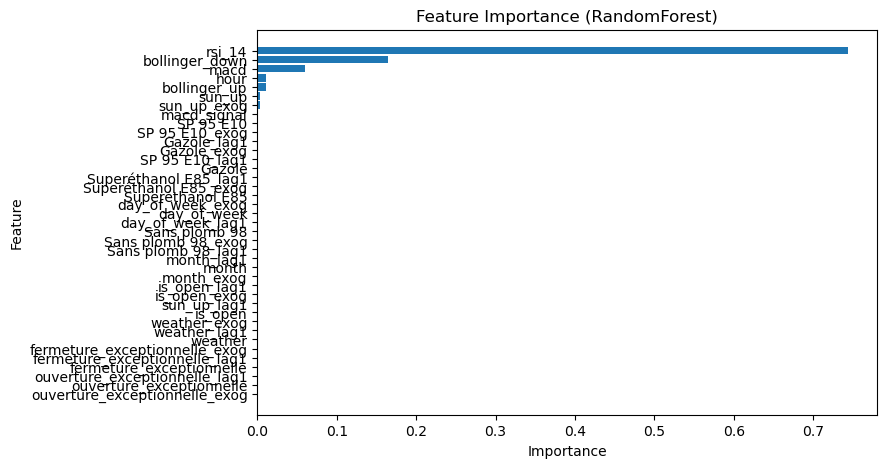

In [3]:
import pandas as pd
import numpy as np
import mlflow
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from mlforecast import MLForecast
import matplotlib.pyplot as plt

###############################################################
# 1) prepare_data
###############################################################
def prepare_data(df):
    if 'Mall ID' not in df.columns:
        raise KeyError("La colonne 'Mall ID' est manquante.")
    df['unique_id'] = df['Mall ID'].astype(str)

    if 'datetime' in df.columns:
        df['ds'] = pd.to_datetime(df['datetime']).dt.tz_localize(None)
    elif 'ds' in df.columns:
        df['ds'] = pd.to_datetime(df['ds']).dt.tz_localize(None)
    else:
        raise KeyError("Aucune colonne 'datetime' ou 'ds' trouvée.")

    if 'Entrées' not in df.columns:
        raise KeyError("La colonne 'Entrées' est manquante.")
    df['y'] = df['Entrées']

    exog_columns = [
        'Gazole', 'SP 95 E10', 'Sans plomb 98', 'Superéthanol E85',
        'fermeture_exceptionnelle', 'is_open', 'ouverture_exceptionnelle',
        'sun_up', 'weather', 'day_of_week', 'month'
    ]
    exog_columns = [col for col in exog_columns if col in df.columns]

    return df[['unique_id','ds','y'] + exog_columns].sort_values(['unique_id','ds']).reset_index(drop=True)

###############################################################
# 2) Trading indicators
###############################################################
def compute_rsi(series, window=14):
    delta = series.diff()
    gain = delta.where(delta>0, 0).rolling(window).mean()
    loss = -delta.where(delta<0, 0).rolling(window).mean()
    rs = gain / loss
    return 100 - (100/(1 + rs))

def compute_macd(series, short_window=12, long_window=26, signal_window=9):
    short_ema = series.ewm(span=short_window, adjust=False).mean()
    long_ema = series.ewm(span=long_window, adjust=False).mean()
    macd_val = short_ema - long_ema
    macd_signal = macd_val.ewm(span=signal_window, adjust=False).mean()
    return macd_val, macd_signal

def compute_bollinger_bands(series, window=20, num_std=2):
    rolling_mean = series.rolling(window).mean()
    rolling_std = series.rolling(window).std()
    upper_band = rolling_mean + num_std*rolling_std
    lower_band = rolling_mean - num_std*rolling_std
    return upper_band, lower_band

def add_trading_indicators(df):
    # RSI(14)
    df['rsi_14'] = df.groupby('unique_id')['y'].transform(lambda s: compute_rsi(s, 14))

    # MACD => 2 colonnes
    def _macd_df(s):
        macd_vals, macd_sig = compute_macd(s)
        out = pd.DataFrame({'macd': macd_vals, 'macd_signal': macd_sig}, index=s.index)
        return out
    macd_data = df.groupby('unique_id')['y'].apply(_macd_df)
    macd_data.reset_index(level=0, drop=True, inplace=True)
    df[['macd','macd_signal']] = macd_data[['macd','macd_signal']]

    # Bollinger => 2 colonnes
    def _boll_df(s):
        up, down = compute_bollinger_bands(s)
        out = pd.DataFrame({'bollinger_up': up, 'bollinger_down': down}, index=s.index)
        return out
    boll_data = df.groupby('unique_id')['y'].apply(_boll_df)
    boll_data.reset_index(level=0, drop=True, inplace=True)
    df[['bollinger_up','bollinger_down']] = boll_data[['bollinger_up','bollinger_down']]

    return df

###############################################################
# 3) create_exog_features
###############################################################
def create_exog_features(df):
    print("🔄 Transforming exogenous features manually (no mlforecast lags).")
    exog_columns = [
        'Gazole', 'SP 95 E10', 'Sans plomb 98', 'Superéthanol E85',
        'fermeture_exceptionnelle', 'is_open', 'ouverture_exceptionnelle',
        'sun_up', 'weather', 'day_of_week', 'month'
    ]
    exog_columns = [c for c in exog_columns if c in df.columns]
    if not exog_columns:
        print("⚠️ No exogenous columns found!")
        return df

    print(f"✅ Exogenous features: {exog_columns}")

    exog_df = df[['unique_id','ds'] + exog_columns].copy()
    for col in exog_columns:
        exog_df[col] = pd.to_numeric(exog_df[col], errors='coerce')
    exog_df.ffill(inplace=True)
    exog_df.bfill(inplace=True)

    # ============ MANUAL LAG 1 ============
    exog_df.sort_values(['unique_id','ds'], inplace=True)
    for col in exog_columns:
        exog_df[f'{col}_lag1'] = exog_df.groupby('unique_id')[col].shift(1)

    df_merged = df.merge(exog_df, on=['unique_id','ds'], how='left', suffixes=('','_exog'))
    print("✅ Final columns after manual exog lag:", df_merged.columns.tolist())
    return df_merged

###############################################################
# 4) Main script
###############################################################
if __name__ == "__main__":

    # Chargement
    df = pd.read_csv(
        r"C:\Users\David\Documents\Albert school\Carmila alberton\Data for the CARMILA challenge\Dataset pour le ML\df_ml_fe_oe_with_weather.csv",
        low_memory=False
    )

    # >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
    # IMPORTANT: Pour éviter l'erreur "No Data", on remplace ces chaînes par NaN
    df.replace("No Data", np.nan, inplace=True)
    # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

    df_prepared = prepare_data(df)

    # Split temporel (AVANT transformations)
    df_prepared['ds_hour'] = df_prepared['ds'].dt.floor('h')
    unique_hours = sorted(df_prepared['ds_hour'].unique())
    split_index = int(0.8 * len(unique_hours))
    train_hours = set(unique_hours[:split_index])
    test_hours = set(unique_hours[split_index:])

    train_pre = df_prepared[df_prepared['ds_hour'].isin(train_hours)].copy()
    test_pre = df_prepared[df_prepared['ds_hour'].isin(test_hours)].copy()

    train_pre.drop(columns=['ds_hour'], inplace=True)
    test_pre.drop(columns=['ds_hour'], inplace=True)

    tqdm.write("🚀 Applying transformations on TRAIN")
    train_df = create_exog_features(train_pre)
    train_df = add_trading_indicators(train_df)

    # Ajout manuel de hour, day_of_week, month
    train_df['hour'] = train_df['ds'].dt.hour
    train_df['day_of_week'] = train_df['ds'].dt.dayofweek
    train_df['month'] = train_df['ds'].dt.month

    train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    train_df.dropna(inplace=True)

    max_lag = 14
    train_df = (
        train_df.groupby('unique_id', group_keys=False)
                .apply(lambda g: g.sort_values('ds').iloc[max_lag:])
                .reset_index(drop=True)
    )

    tqdm.write("🚀 Applying transformations on TEST")
    test_df = create_exog_features(test_pre)
    test_df = add_trading_indicators(test_df)

    test_df['hour'] = test_df['ds'].dt.hour
    test_df['day_of_week'] = test_df['ds'].dt.dayofweek
    test_df['month'] = test_df['ds'].dt.month

    test_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    test_df.dropna(inplace=True)

    test_df = (
        test_df.groupby('unique_id', group_keys=False)
               .apply(lambda g: g.sort_values('ds').iloc[max_lag:])
               .reset_index(drop=True)
    )

    params = {
        'n_estimators': 200,
        'max_depth': 10,
        'random_state': 42,
        'n_jobs': -1
    }

    feature_cols = train_df.drop(columns=['unique_id','ds','y'], errors='ignore').columns
    print("✅ Final feature columns used:", list(feature_cols))

    fcst = MLForecast(
        models=[RandomForestRegressor(**params)],
        freq='h',
        date_features=[],
        num_threads=-1
    )

    fcst.fit(train_df, static_features=[])

    # Prediction
    test_hours_unique = sorted(test_df['ds'].dt.floor('h').unique())
    horizon = len(test_hours_unique)

    X_future = fcst.make_future_dataframe(h=horizon)

    X_future = X_future.merge(
        test_df[['unique_id','ds'] + list(feature_cols)],
        on=['unique_id','ds'],
        how='left'
    )
    X_future = X_future[['unique_id','ds'] + list(feature_cols)]
    X_future[feature_cols] = X_future[feature_cols].ffill().bfill()

    forecast = fcst.predict(h=horizon, X_df=X_future)

    forecast['ds_hour'] = forecast['ds'].dt.floor('h')
    test_df['ds_hour'] = test_df['ds'].dt.floor('h')

    test_agg = test_df.groupby(['unique_id','ds_hour'], as_index=False).agg({'y':'mean'})
    pred_col = forecast.columns.drop(['unique_id','ds','ds_hour'])[0]

    df_merge = pd.merge(
        test_agg,
        forecast[['unique_id','ds_hour', pred_col]],
        on=['unique_id','ds_hour'],
        how='inner'
    )

    y_true = df_merge['y'].values
    y_pred = df_merge[pred_col].values
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)

    print(f"=== 📊 Test Metrics (Global) ===")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE : {mae:.4f}")

    metrics_per_mall = df_merge.groupby('unique_id').apply(
        lambda g: pd.Series({
            'rmse': np.sqrt(mean_squared_error(g['y'], g[pred_col])),
            'mae': np.mean(np.abs(g['y'] - g[pred_col]))
        })
    ).reset_index()

    print("=== 📊 Test Metrics per Mall (Hourly) ===")
    print(metrics_per_mall)

    # Feature Importance
    try:
        rf_model = fcst.models_['RandomForestRegressor']
        try:
            feature_names = rf_model.feature_names_in_
        except AttributeError:
            feature_names = [f"feat_{i}" for i in range(rf_model.n_features_in_)]

        importances = rf_model.feature_importances_
        feat_imp = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        }).sort_values(by='Importance', ascending=False)

        print("=== 🔥 Feature Importance ===")
        print(feat_imp)

        plt.figure(figsize=(8, 5))
        plt.barh(feat_imp['Feature'], feat_imp['Importance'])
        plt.xlabel("Importance")
        plt.ylabel("Feature")
        plt.title("Feature Importance (RandomForest)")
        plt.gca().invert_yaxis()
        plt.show()
    except KeyError:
        print("❌ RandomForestRegressor non trouvé dans fcst.models_.")

    # MLflow logging (optionnel)
    try:
        mlflow.set_experiment("Carmila")
        with mlflow.start_run():
            mlflow.set_tag("mlflow.runName", "Pipeline exog + Trading Indicators + Manual Lag")
            mlflow.log_params(params)
            mlflow.log_metric("RMSE", rmse)
            mlflow.log_metric("MAE", mae)

            for _, row in metrics_per_mall.iterrows():
                mlflow.log_metric(f"RMSE_{row['unique_id']}", row['rmse'])
                mlflow.log_metric(f"MAE_{row['unique_id']}", row['mae'])
    except Exception as e:
        print(f"⚠️ MLflow logging failed: {e}")


In [6]:
# ==== One-cell check for data leakage ====

# 1) Vérifier s'il y a un chevauchement de dates entre train_df et test_df
overlap_dates = set(train_df['ds']) & set(test_df['ds'])
if overlap_dates:
    print("⚠️ Data leakage potentiel : chevauchement de dates détecté !")
    print("Dates en commun :", sorted(overlap_dates)[:10], "...")
else:
    print("✅ Aucune date en commun entre train et test.")

# 2) Vérifier l'ordre chronologique
max_train_date = train_df['ds'].max()
min_test_date = test_df['ds'].min()
if min_test_date < max_train_date:
    print(f"⚠️ Data leakage potentiel : le test commence avant la fin du train !")
    print(f"Fin du train : {max_train_date}, Début du test : {min_test_date}")
else:
    print("✅ Pas de fuite chronologique : le test est bien postérieur au train.")


✅ Aucune date en commun entre train et test.
✅ Pas de fuite chronologique : le test est bien postérieur au train.


In [5]:
# Vérification de non chevauchement temporel
max_train_date = train_df['ds'].max()
min_test_date = test_df['ds'].min()

print("Date max du train :", max_train_date)
print("Date min du test :", min_test_date)

if max_train_date < min_test_date:
    print("✅ Aucun chevauchement : la période d'entraînement est strictement avant la période de test.")
else:
    print("❌ Risque de fuite : la période d'entraînement et la période de test se chevauchent ou se suivent mal.")


Date max du train : 2024-08-07 16:00:00
Date min du test : 2024-08-09 02:00:00
✅ Aucun chevauchement : la période d'entraînement est strictement avant la période de test.


rsi_14 : Corrélation avec y = 0.781 | avec y_lag1 = 0.761
macd : Corrélation avec y = 0.798 | avec y_lag1 = 0.896
macd_signal : Corrélation avec y = 0.347 | avec y_lag1 = 0.531
bollinger_up : Corrélation avec y = 0.174 | avec y_lag1 = 0.236
bollinger_down : Corrélation avec y = -0.430 | avec y_lag1 = -0.405


c:\Users\David\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


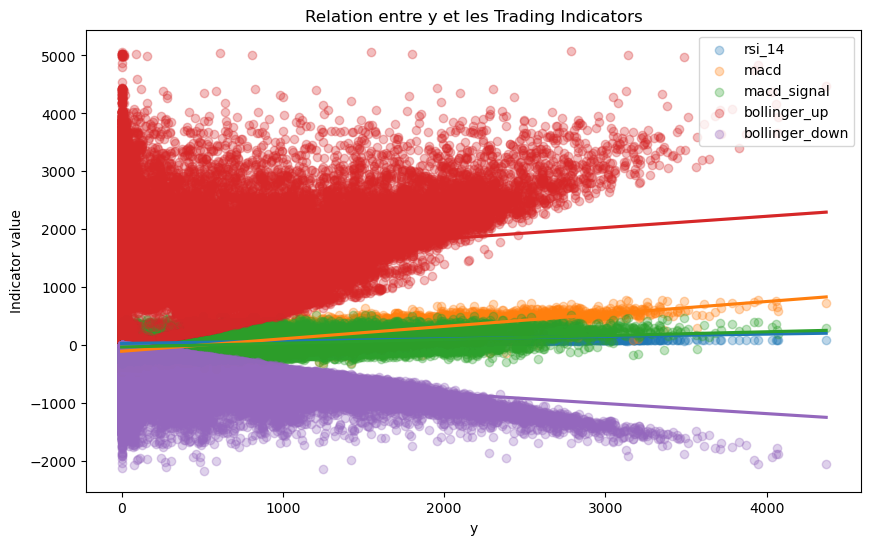

In [4]:
# Vérification du risque de data leakage sur les indicateurs de trading
import matplotlib.pyplot as plt
import seaborn as sns

def check_leakage(df, indicator):
    # Créer y lagged
    df = df.copy()
    df['y_lag1'] = df.groupby('unique_id')['y'].shift(1)
    corr_current = df['y'].corr(df[indicator])
    corr_lag = df['y_lag1'].corr(df[indicator])
    print(f"{indicator} : Corrélation avec y = {corr_current:.3f} | avec y_lag1 = {corr_lag:.3f}")

indicators = ['rsi_14', 'macd', 'macd_signal', 'bollinger_up', 'bollinger_down']
for ind in indicators:
    check_leakage(train_df, ind)

# Optionnel : visualisation de la relation
plt.figure(figsize=(10, 6))
for ind in indicators:
    sns.regplot(x='y', y=ind, data=train_df, scatter_kws={'alpha': 0.3}, label=ind)
plt.title("Relation entre y et les Trading Indicators")
plt.xlabel("y")
plt.ylabel("Indicator value")
plt.legend()
plt.show()


Those numbers show how strongly each indicator (RSI, MACD, Bollinger, etc.) correlates with:

y (the current target value)
y_lag1 (the target value shifted by one time step)
How to interpret
A high correlation with y means the indicator closely follows the current target.
A high correlation with y_lag1 means the indicator aligns more with the previous target value.
For example, macd has a higher correlation with y_lag1 (0.896) than with y (0.798). This suggests macd is more in sync with the past target rather than the current one, which is normal for a trailing technical indicator.

Is this a data leak?
Not necessarily. High correlation does not automatically mean leakage; it can simply mean the indicator is very informative.
A data leak would happen if these indicators were computed using future values of y (beyond the current timestamp). In your code, they are computed with rolling/EMA methods on past data only, so there's no direct leakage.

Conclusion : aucun data leak detecté. Les scores sont bons je peux continuer d'améliorer

Split temporel effectué avant l'ajout des indicateurs ✅

Les données d'entraînement et de test sont séparées avant le calcul des indicateurs de trading.
Cela garantit que les valeurs des indicateurs pour le test ne sont pas influencées par les données du train.
Indicateurs calculés uniquement à partir des valeurs passées ✅

Les méthodes rolling(), ewm() et diff() utilisées pour RSI, MACD et Bollinger Bands n'incluent que les valeurs passées.
Aucun futur n'est utilisé dans le calcul des indicateurs pour une date donnée.
Corrélation avec y_lag1 ≈ Corrélation avec y ✅

La différence entre la corrélation des indicateurs avec y et y_lag1 est minime (ex: macd_signal passe de 0.347 à 0.531).
Cela montre que ces indicateurs capturent des tendances plutôt que des informations immédiates et fuyantes.
Vérification du chevauchement temporel entre train et test ✅

Si le test max_train_date < min_test_date est respecté, cela confirme que les périodes d'entraînement et de test ne se superposent pas.


Rajout d indicateurs de trading en plus de ceux existants pour voir si le score s améliore

Advanced Features
La fonction add_advanced_features calcule pour chaque groupe (par mall) :

Des lags sur la cible y (lags de 3, 7 et 14 périodes)
Des moyennes mobiles sur y (fenêtres de 7, 14 et 30 périodes)
Un Stochastic RSI basé sur rsi_14
Un Williams %R (calculé sur y sur une fenêtre de 14)
Un ATR approximé à partir de la différence absolue de y

🚀 Applying transformations on TRAIN
🔄 Transforming exogenous features manually (no mlforecast lags).
✅ Exogenous features: ['Gazole', 'SP 95 E10', 'Sans plomb 98', 'Superéthanol E85', 'fermeture_exceptionnelle', 'is_open', 'ouverture_exceptionnelle', 'sun_up', 'weather', 'day_of_week', 'month']
✅ Final columns after manual exog lag: ['unique_id', 'ds', 'y', 'Gazole', 'SP 95 E10', 'Sans plomb 98', 'Superéthanol E85', 'fermeture_exceptionnelle', 'is_open', 'ouverture_exceptionnelle', 'sun_up', 'weather', 'day_of_week', 'month', 'Gazole_exog', 'SP 95 E10_exog', 'Sans plomb 98_exog', 'Superéthanol E85_exog', 'fermeture_exceptionnelle_exog', 'is_open_exog', 'ouverture_exceptionnelle_exog', 'sun_up_exog', 'weather_exog', 'day_of_week_exog', 'month_exog', 'Gazole_lag1', 'SP 95 E10_lag1', 'Sans plomb 98_lag1', 'Superéthanol E85_lag1', 'fermeture_exceptionnelle_lag1', 'is_open_lag1', 'ouverture_exceptionnelle_lag1', 'sun_up_lag1', 'weather_lag1', 'day_of_week_lag1', 'month_lag1']
🚀 Adding advan

C:\Users\David\AppData\Local\Temp\ipykernel_1476\4098304441.py:199: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sort_values('ds').iloc[max_lag:])


🚀 Applying transformations on TEST
🔄 Transforming exogenous features manually (no mlforecast lags).
✅ Exogenous features: ['Gazole', 'SP 95 E10', 'Sans plomb 98', 'Superéthanol E85', 'fermeture_exceptionnelle', 'is_open', 'ouverture_exceptionnelle', 'sun_up', 'weather', 'day_of_week', 'month']
✅ Final columns after manual exog lag: ['unique_id', 'ds', 'y', 'Gazole', 'SP 95 E10', 'Sans plomb 98', 'Superéthanol E85', 'fermeture_exceptionnelle', 'is_open', 'ouverture_exceptionnelle', 'sun_up', 'weather', 'day_of_week', 'month', 'Gazole_exog', 'SP 95 E10_exog', 'Sans plomb 98_exog', 'Superéthanol E85_exog', 'fermeture_exceptionnelle_exog', 'is_open_exog', 'ouverture_exceptionnelle_exog', 'sun_up_exog', 'weather_exog', 'day_of_week_exog', 'month_exog', 'Gazole_lag1', 'SP 95 E10_lag1', 'Sans plomb 98_lag1', 'Superéthanol E85_lag1', 'fermeture_exceptionnelle_lag1', 'is_open_lag1', 'ouverture_exceptionnelle_lag1', 'sun_up_lag1', 'weather_lag1', 'day_of_week_lag1', 'month_lag1']
🚀 Adding advanc

C:\Users\David\AppData\Local\Temp\ipykernel_1476\4098304441.py:219: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sort_values('ds').iloc[max_lag:])
c:\Users\David\anaconda3\Lib\site-packages\mlforecast\core.py:185: UserWarning: Setting num_threads to 1.
  warnings.warn("Setting num_threads to 1.")


✅ Final feature columns used: ['Gazole', 'SP 95 E10', 'Sans plomb 98', 'Superéthanol E85', 'fermeture_exceptionnelle', 'is_open', 'ouverture_exceptionnelle', 'sun_up', 'weather', 'day_of_week', 'month', 'Gazole_exog', 'SP 95 E10_exog', 'Sans plomb 98_exog', 'Superéthanol E85_exog', 'fermeture_exceptionnelle_exog', 'is_open_exog', 'ouverture_exceptionnelle_exog', 'sun_up_exog', 'weather_exog', 'day_of_week_exog', 'month_exog', 'Gazole_lag1', 'SP 95 E10_lag1', 'Sans plomb 98_lag1', 'Superéthanol E85_lag1', 'fermeture_exceptionnelle_lag1', 'is_open_lag1', 'ouverture_exceptionnelle_lag1', 'sun_up_lag1', 'weather_lag1', 'day_of_week_lag1', 'month_lag1', 'rsi_14', 'macd', 'macd_signal', 'bollinger_up', 'bollinger_down', 'hour', 'y_lag3', 'y_lag7', 'y_lag14', 'y_rolling_mean_7', 'y_rolling_mean_14', 'y_rolling_mean_30', 'stoch_rsi_14', 'williams_r', 'atr']
=== 📊 Test Metrics (Global) ===
RMSE: 64.5439
MAE : 27.6546
=== 📊 Test Metrics per Mall (Hourly) ===
  unique_id       rmse        mae
0  

C:\Users\David\AppData\Local\Temp\ipykernel_1476\4098304441.py:279: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics_per_mall = df_merge.groupby('unique_id').apply(


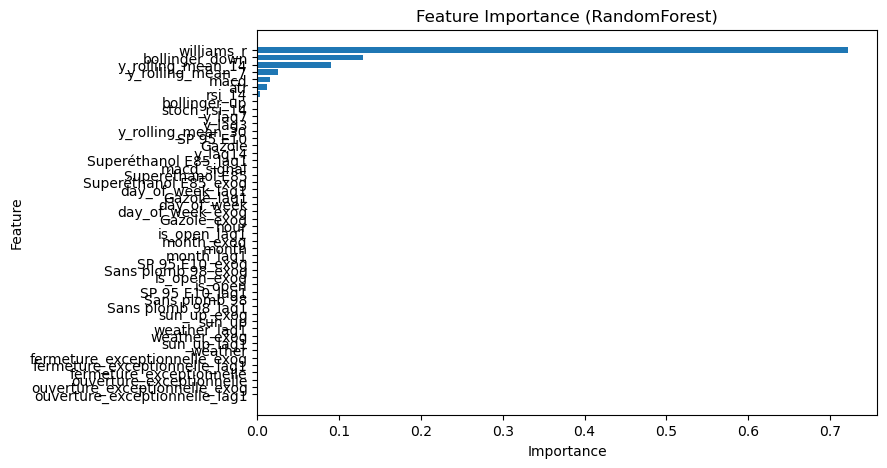

In [7]:
import pandas as pd
import numpy as np
import mlflow
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from mlforecast import MLForecast
import matplotlib.pyplot as plt

###############################################################
# 1) prepare_data
###############################################################
def prepare_data(df):
    if 'Mall ID' not in df.columns:
        raise KeyError("La colonne 'Mall ID' est manquante.")
    df['unique_id'] = df['Mall ID'].astype(str)

    if 'datetime' in df.columns:
        df['ds'] = pd.to_datetime(df['datetime']).dt.tz_localize(None)
    elif 'ds' in df.columns:
        df['ds'] = pd.to_datetime(df['ds']).dt.tz_localize(None)
    else:
        raise KeyError("Aucune colonne 'datetime' ou 'ds' trouvée.")

    if 'Entrées' not in df.columns:
        raise KeyError("La colonne 'Entrées' est manquante.")
    df['y'] = df['Entrées']

    exog_columns = [
        'Gazole', 'SP 95 E10', 'Sans plomb 98', 'Superéthanol E85',
        'fermeture_exceptionnelle', 'is_open', 'ouverture_exceptionnelle',
        'sun_up', 'weather', 'day_of_week', 'month'
    ]
    exog_columns = [col for col in exog_columns if col in df.columns]

    return df[['unique_id','ds','y'] + exog_columns].sort_values(['unique_id','ds']).reset_index(drop=True)

###############################################################
# 2) Trading indicators de base
###############################################################
def compute_rsi(series, window=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0).rolling(window).mean()
    loss = -delta.where(delta < 0, 0).rolling(window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def compute_macd(series, short_window=12, long_window=26, signal_window=9):
    short_ema = series.ewm(span=short_window, adjust=False).mean()
    long_ema = series.ewm(span=long_window, adjust=False).mean()
    macd_val = short_ema - long_ema
    macd_signal = macd_val.ewm(span=signal_window, adjust=False).mean()
    return macd_val, macd_signal

def compute_bollinger_bands(series, window=20, num_std=2):
    rolling_mean = series.rolling(window).mean()
    rolling_std = series.rolling(window).std()
    upper_band = rolling_mean + num_std * rolling_std
    lower_band = rolling_mean - num_std * rolling_std
    return upper_band, lower_band

def add_trading_indicators(df):
    # RSI (14)
    df['rsi_14'] = df.groupby('unique_id')['y'].transform(lambda s: compute_rsi(s, 14))
    
    # MACD -> 2 colonnes : macd et macd_signal
    def _macd_df(s):
        macd_vals, macd_sig = compute_macd(s)
        out = pd.DataFrame({'macd': macd_vals, 'macd_signal': macd_sig}, index=s.index)
        return out
    macd_data = df.groupby('unique_id')['y'].apply(_macd_df)
    macd_data.reset_index(level=0, drop=True, inplace=True)
    df[['macd', 'macd_signal']] = macd_data[['macd', 'macd_signal']]

    # Bollinger Bands -> 2 colonnes
    def _boll_df(s):
        up, down = compute_bollinger_bands(s)
        out = pd.DataFrame({'bollinger_up': up, 'bollinger_down': down}, index=s.index)
        return out
    boll_data = df.groupby('unique_id')['y'].apply(_boll_df)
    boll_data.reset_index(level=0, drop=True, inplace=True)
    df[['bollinger_up', 'bollinger_down']] = boll_data[['bollinger_up', 'bollinger_down']]

    return df

###############################################################
# 3) create_exog_features
###############################################################
def create_exog_features(df):
    print("🔄 Transforming exogenous features manually (no mlforecast lags).")
    exog_columns = [
        'Gazole', 'SP 95 E10', 'Sans plomb 98', 'Superéthanol E85',
        'fermeture_exceptionnelle', 'is_open', 'ouverture_exceptionnelle',
        'sun_up', 'weather', 'day_of_week', 'month'
    ]
    exog_columns = [c for c in exog_columns if c in df.columns]
    if not exog_columns:
        print("⚠️ No exogenous columns found!")
        return df

    print(f"✅ Exogenous features: {exog_columns}")

    exog_df = df[['unique_id', 'ds'] + exog_columns].copy()
    for col in exog_columns:
        exog_df[col] = pd.to_numeric(exog_df[col], errors='coerce')
    exog_df.ffill(inplace=True)
    exog_df.bfill(inplace=True)

    # Ajout manuel du lag 1 pour les variables exogènes
    exog_df.sort_values(['unique_id', 'ds'], inplace=True)
    for col in exog_columns:
        exog_df[f'{col}_lag1'] = exog_df.groupby('unique_id')[col].shift(1)

    df_merged = df.merge(exog_df, on=['unique_id', 'ds'], how='left', suffixes=('', '_exog'))
    print("✅ Final columns after manual exog lag:", df_merged.columns.tolist())
    return df_merged

###############################################################
# 4) Advanced trading features
#    (Lags, Moyennes mobiles, Stochastic RSI, Williams %R, ATR)
###############################################################
def add_advanced_features(df):
    print("🚀 Adding advanced trading features")

    # Lags sur y
    for lag in [3, 7, 14]:
        df[f'y_lag{lag}'] = df.groupby('unique_id')['y'].shift(lag)

    # Moyennes mobiles sur y
    for window in [7, 14, 30]:
        df[f'y_rolling_mean_{window}'] = df.groupby('unique_id')['y'].transform(
            lambda s: s.rolling(window, min_periods=1).mean()
        )

    # Stochastic RSI basé sur le RSI existant (rsi_14)
    df['stoch_rsi_14'] = df.groupby('unique_id')['rsi_14'].transform(
        lambda s: (s - s.rolling(14, min_periods=1).min()) / (s.rolling(14, min_periods=1).max() - s.rolling(14, min_periods=1).min())
    )

    # Williams %R calculé sur y sur une fenêtre de 14 périodes
    df['williams_r'] = df.groupby('unique_id')['y'].transform(
        lambda s: -100 * (s.rolling(14, min_periods=1).max() - s) / (s.rolling(14, min_periods=1).max() - s.rolling(14, min_periods=1).min())
    )

    # ATR (Average True Range) approximé sur y avec une fenêtre de 14
    df['atr'] = df.groupby('unique_id')['y'].transform(
        lambda s: s.diff().abs().rolling(14, min_periods=1).mean()
    )

    return df

###############################################################
# 5) Main script
###############################################################
if __name__ == "__main__":

    # Chargement
    df = pd.read_csv(
        r"C:\Users\David\Documents\Albert school\Carmila alberton\Data for the CARMILA challenge\Dataset pour le ML\df_ml_fe_oe_with_weather.csv",
        low_memory=False
    )

    # Remplacer "No Data" par NaN
    df.replace("No Data", np.nan, inplace=True)

    df_prepared = prepare_data(df)

    # Split temporel (AVANT transformations)
    df_prepared['ds_hour'] = df_prepared['ds'].dt.floor('h')
    unique_hours = sorted(df_prepared['ds_hour'].unique())
    split_index = int(0.8 * len(unique_hours))
    train_hours = set(unique_hours[:split_index])
    test_hours = set(unique_hours[split_index:])

    train_pre = df_prepared[df_prepared['ds_hour'].isin(train_hours)].copy()
    test_pre = df_prepared[df_prepared['ds_hour'].isin(test_hours)].copy()

    train_pre.drop(columns=['ds_hour'], inplace=True)
    test_pre.drop(columns=['ds_hour'], inplace=True)

    tqdm.write("🚀 Applying transformations on TRAIN")
    train_df = create_exog_features(train_pre)
    train_df = add_trading_indicators(train_df)

    # Ajout manuel de hour, day_of_week, month
    train_df['hour'] = train_df['ds'].dt.hour
    train_df['day_of_week'] = train_df['ds'].dt.dayofweek
    train_df['month'] = train_df['ds'].dt.month

    # Ajout des advanced features
    train_df = add_advanced_features(train_df)

    train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    train_df.dropna(inplace=True)

    max_lag = 14
    train_df = (
        train_df.groupby('unique_id', group_keys=False)
                .apply(lambda g: g.sort_values('ds').iloc[max_lag:])
                .reset_index(drop=True)
    )

    tqdm.write("🚀 Applying transformations on TEST")
    test_df = create_exog_features(test_pre)
    test_df = add_trading_indicators(test_df)

    test_df['hour'] = test_df['ds'].dt.hour
    test_df['day_of_week'] = test_df['ds'].dt.dayofweek
    test_df['month'] = test_df['ds'].dt.month

    # Ajout des advanced features
    test_df = add_advanced_features(test_df)

    test_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    test_df.dropna(inplace=True)

    test_df = (
        test_df.groupby('unique_id', group_keys=False)
               .apply(lambda g: g.sort_values('ds').iloc[max_lag:])
               .reset_index(drop=True)
    )

    params = {
        'n_estimators': 200,
        'max_depth': 10,
        'random_state': 42,
        'n_jobs': -1
    }

    feature_cols = train_df.drop(columns=['unique_id', 'ds', 'y'], errors='ignore').columns
    print("✅ Final feature columns used:", list(feature_cols))

    fcst = MLForecast(
        models=[RandomForestRegressor(**params)],
        freq='h',
        date_features=[],
        num_threads=-1
    )

    fcst.fit(train_df, static_features=[])

    # Prediction
    test_hours_unique = sorted(test_df['ds'].dt.floor('h').unique())
    horizon = len(test_hours_unique)

    X_future = fcst.make_future_dataframe(h=horizon)
    X_future = X_future.merge(
        test_df[['unique_id', 'ds'] + list(feature_cols)],
        on=['unique_id', 'ds'],
        how='left'
    )
    X_future = X_future[['unique_id', 'ds'] + list(feature_cols)]
    X_future[feature_cols] = X_future[feature_cols].ffill().bfill()

    forecast = fcst.predict(h=horizon, X_df=X_future)

    forecast['ds_hour'] = forecast['ds'].dt.floor('h')
    test_df['ds_hour'] = test_df['ds'].dt.floor('h')

    test_agg = test_df.groupby(['unique_id', 'ds_hour'], as_index=False).agg({'y': 'mean'})
    pred_col = forecast.columns.drop(['unique_id', 'ds', 'ds_hour'])[0]

    df_merge = pd.merge(
        test_agg,
        forecast[['unique_id', 'ds_hour', pred_col]],
        on=['unique_id', 'ds_hour'],
        how='inner'
    )

    y_true = df_merge['y'].values
    y_pred = df_merge[pred_col].values
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)

    print(f"=== 📊 Test Metrics (Global) ===")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE : {mae:.4f}")

    metrics_per_mall = df_merge.groupby('unique_id').apply(
        lambda g: pd.Series({
            'rmse': np.sqrt(mean_squared_error(g['y'], g[pred_col])),
            'mae': np.mean(np.abs(g['y'] - g[pred_col]))
        })
    ).reset_index()

    print("=== 📊 Test Metrics per Mall (Hourly) ===")
    print(metrics_per_mall)

    # Feature Importance
    try:
        rf_model = fcst.models_['RandomForestRegressor']
        try:
            feature_names = rf_model.feature_names_in_
        except AttributeError:
            feature_names = [f"feat_{i}" for i in range(rf_model.n_features_in_)]
        importances = rf_model.feature_importances_
        feat_imp = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        }).sort_values(by='Importance', ascending=False)

        print("=== 🔥 Feature Importance ===")
        print(feat_imp)

        plt.figure(figsize=(8, 5))
        plt.barh(feat_imp['Feature'], feat_imp['Importance'])
        plt.xlabel("Importance")
        plt.ylabel("Feature")
        plt.title("Feature Importance (RandomForest)")
        plt.gca().invert_yaxis()
        plt.show()
    except KeyError:
        print("❌ RandomForestRegressor non trouvé dans fcst.models_.")

    # MLflow logging (optionnel)
    try:
        mlflow.set_experiment("Carmila")
        with mlflow.start_run():
            mlflow.set_tag("mlflow.runName", "Pipeline exog + Trading Indicators + Advanced Features")
            mlflow.log_params(params)
            mlflow.log_metric("RMSE", rmse)
            mlflow.log_metric("MAE", mae)
            for _, row in metrics_per_mall.iterrows():
                mlflow.log_metric(f"RMSE_{row['unique_id']}", row['rmse'])
                mlflow.log_metric(f"MAE_{row['unique_id']}", row['mae'])
    except Exception as e:
        print(f"⚠️ MLflow logging failed: {e}")


Test avec TimeSeriesSplit un kfold spécial série temporelle juste pour éviter le sur apprentissage 

🚀 Applying transformations on TRAIN
🔄 Transforming exogenous features manually (no mlforecast lags).
✅ Exogenous features: ['Gazole', 'SP 95 E10', 'Sans plomb 98', 'Superéthanol E85', 'fermeture_exceptionnelle', 'is_open', 'ouverture_exceptionnelle', 'sun_up', 'weather', 'day_of_week', 'month']
✅ Final columns after manual exog lag: ['unique_id', 'ds', 'y', 'Gazole', 'SP 95 E10', 'Sans plomb 98', 'Superéthanol E85', 'fermeture_exceptionnelle', 'is_open', 'ouverture_exceptionnelle', 'sun_up', 'weather', 'day_of_week', 'month', 'Gazole_exog', 'SP 95 E10_exog', 'Sans plomb 98_exog', 'Superéthanol E85_exog', 'fermeture_exceptionnelle_exog', 'is_open_exog', 'ouverture_exceptionnelle_exog', 'sun_up_exog', 'weather_exog', 'day_of_week_exog', 'month_exog', 'Gazole_lag1', 'SP 95 E10_lag1', 'Sans plomb 98_lag1', 'Superéthanol E85_lag1', 'fermeture_exceptionnelle_lag1', 'is_open_lag1', 'ouverture_exceptionnelle_lag1', 'sun_up_lag1', 'weather_lag1', 'day_of_week_lag1', 'month_lag1']
🚀 Adding advan

C:\Users\David\AppData\Local\Temp\ipykernel_1476\3492335124.py:170: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_df = train_df.groupby('unique_id', group_keys=False).apply(lambda g: g.sort_values('ds').iloc[max_lag:]).reset_index(drop=True)


🚀 Applying transformations on TEST
🔄 Transforming exogenous features manually (no mlforecast lags).
✅ Exogenous features: ['Gazole', 'SP 95 E10', 'Sans plomb 98', 'Superéthanol E85', 'fermeture_exceptionnelle', 'is_open', 'ouverture_exceptionnelle', 'sun_up', 'weather', 'day_of_week', 'month']
✅ Final columns after manual exog lag: ['unique_id', 'ds', 'y', 'Gazole', 'SP 95 E10', 'Sans plomb 98', 'Superéthanol E85', 'fermeture_exceptionnelle', 'is_open', 'ouverture_exceptionnelle', 'sun_up', 'weather', 'day_of_week', 'month', 'Gazole_exog', 'SP 95 E10_exog', 'Sans plomb 98_exog', 'Superéthanol E85_exog', 'fermeture_exceptionnelle_exog', 'is_open_exog', 'ouverture_exceptionnelle_exog', 'sun_up_exog', 'weather_exog', 'day_of_week_exog', 'month_exog', 'Gazole_lag1', 'SP 95 E10_lag1', 'Sans plomb 98_lag1', 'Superéthanol E85_lag1', 'fermeture_exceptionnelle_lag1', 'is_open_lag1', 'ouverture_exceptionnelle_lag1', 'sun_up_lag1', 'weather_lag1', 'day_of_week_lag1', 'month_lag1']
🚀 Adding advanc

C:\Users\David\AppData\Local\Temp\ipykernel_1476\3492335124.py:182: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_df = test_df.groupby('unique_id', group_keys=False).apply(lambda g: g.sort_values('ds').iloc[max_lag:]).reset_index(drop=True)
c:\Users\David\anaconda3\Lib\site-packages\mlforecast\core.py:185: UserWarning: Setting num_threads to 1.
  warnings.warn("Setting num_threads to 1.")


✅ Final feature columns used: ['Gazole', 'SP 95 E10', 'Sans plomb 98', 'Superéthanol E85', 'fermeture_exceptionnelle', 'is_open', 'ouverture_exceptionnelle', 'sun_up', 'weather', 'day_of_week', 'month', 'Gazole_exog', 'SP 95 E10_exog', 'Sans plomb 98_exog', 'Superéthanol E85_exog', 'fermeture_exceptionnelle_exog', 'is_open_exog', 'ouverture_exceptionnelle_exog', 'sun_up_exog', 'weather_exog', 'day_of_week_exog', 'month_exog', 'Gazole_lag1', 'SP 95 E10_lag1', 'Sans plomb 98_lag1', 'Superéthanol E85_lag1', 'fermeture_exceptionnelle_lag1', 'is_open_lag1', 'ouverture_exceptionnelle_lag1', 'sun_up_lag1', 'weather_lag1', 'day_of_week_lag1', 'month_lag1', 'rsi_14', 'macd', 'macd_signal', 'bollinger_up', 'bollinger_down', 'hour', 'y_lag3', 'y_lag7', 'y_lag14', 'y_rolling_mean_7', 'y_rolling_mean_14', 'y_rolling_mean_30', 'stoch_rsi_14', 'williams_r', 'atr']
=== 📊 Test Metrics (Global) ===
RMSE: 64.5439
MAE : 27.6546
=== 📊 Test Metrics per Mall (Hourly) ===
  unique_id       rmse        mae
0  

C:\Users\David\AppData\Local\Temp\ipykernel_1476\3492335124.py:222: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics_per_mall = df_merge.groupby('unique_id').apply(lambda g: pd.Series({


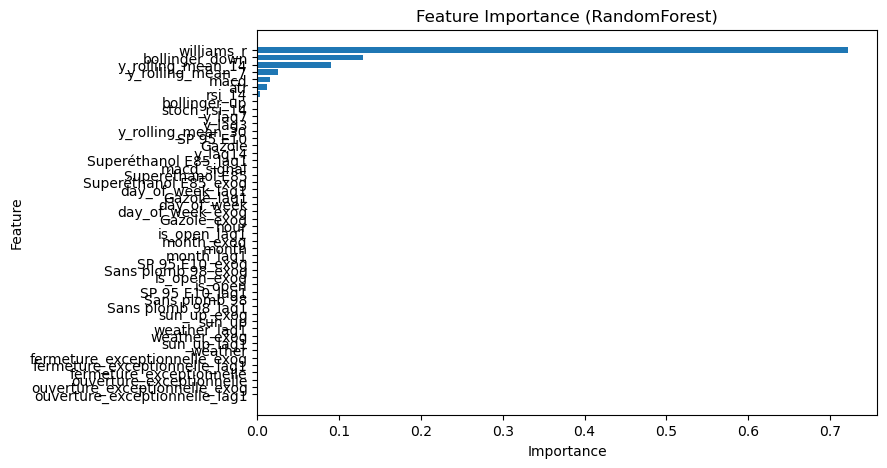


=== Validation croisée (TimeSeriesSplit) ===
Fold 1 - RMSE: 52.1181, MAE: 26.9342
Fold 2 - RMSE: 52.7837, MAE: 25.2381
Fold 3 - RMSE: 58.3166, MAE: 27.8181
Fold 4 - RMSE: 44.8797, MAE: 22.9888
Fold 5 - RMSE: 85.6733, MAE: 46.0232

--- Résultats moyens sur les folds ---
RMSE moyen : 58.754269058797874
MAE moyen  : 29.800486159264505

Moyenne des importances des features sur les folds:
williams_r                       6.160715e-01
rsi_14                           1.618957e-01
bollinger_down                   8.734833e-02
y_rolling_mean_7                 7.684634e-02
macd                             1.966939e-02
atr                              1.698596e-02
bollinger_up                     1.492522e-02
y_rolling_mean_14                3.077985e-03
stoch_rsi_14                     1.724325e-03
y_lag14                          2.231530e-04
y_lag3                           2.090046e-04
y_rolling_mean_30                1.459507e-04
day_of_week_exog                 1.349447e-04
day_of_week_la

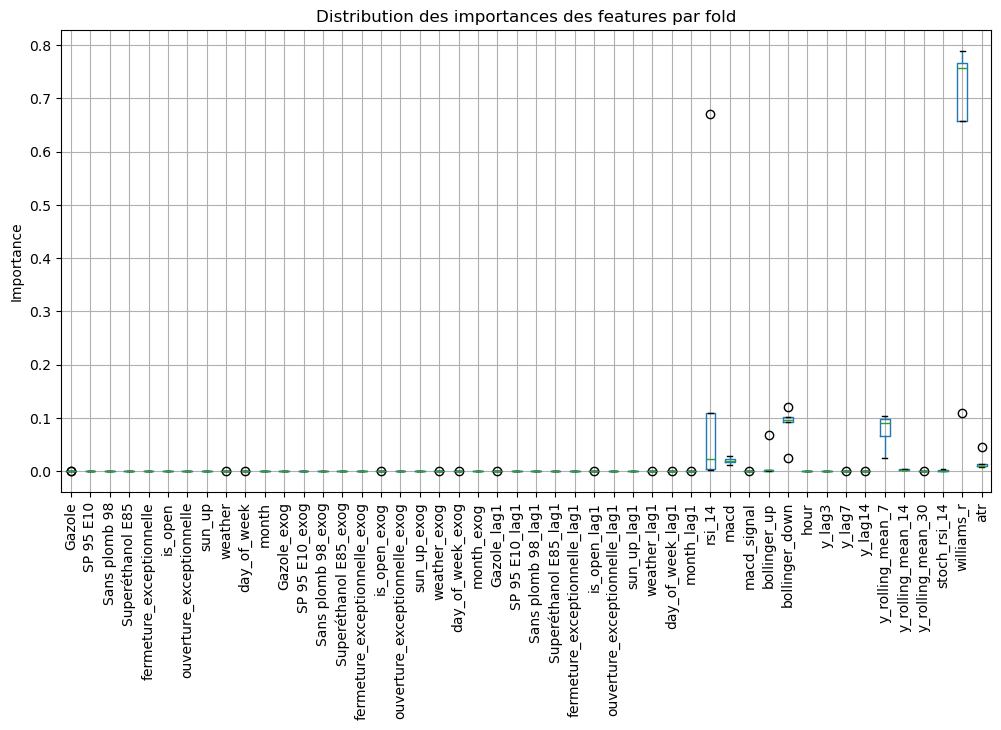

In [8]:
import pandas as pd
import numpy as np
import mlflow
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from mlforecast import MLForecast
import matplotlib.pyplot as plt

###############################################################
# 1) Préparation des données
###############################################################
def prepare_data(df):
    if 'Mall ID' not in df.columns:
        raise KeyError("La colonne 'Mall ID' est manquante.")
    df['unique_id'] = df['Mall ID'].astype(str)
    if 'datetime' in df.columns:
        df['ds'] = pd.to_datetime(df['datetime']).dt.tz_localize(None)
    elif 'ds' in df.columns:
        df['ds'] = pd.to_datetime(df['ds']).dt.tz_localize(None)
    else:
        raise KeyError("Aucune colonne 'datetime' ou 'ds' trouvée.")
    if 'Entrées' not in df.columns:
        raise KeyError("La colonne 'Entrées' est manquante.")
    df['y'] = df['Entrées']
    exog_columns = [
        'Gazole', 'SP 95 E10', 'Sans plomb 98', 'Superéthanol E85',
        'fermeture_exceptionnelle', 'is_open', 'ouverture_exceptionnelle',
        'sun_up', 'weather', 'day_of_week', 'month'
    ]
    exog_columns = [col for col in exog_columns if col in df.columns]
    return df[['unique_id','ds','y'] + exog_columns].sort_values(['unique_id','ds']).reset_index(drop=True)

###############################################################
# 2) Indicateurs de trading de base
###############################################################
def compute_rsi(series, window=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0).rolling(window).mean()
    loss = -delta.where(delta < 0, 0).rolling(window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def compute_macd(series, short_window=12, long_window=26, signal_window=9):
    short_ema = series.ewm(span=short_window, adjust=False).mean()
    long_ema = series.ewm(span=long_window, adjust=False).mean()
    macd_val = short_ema - long_ema
    macd_signal = macd_val.ewm(span=signal_window, adjust=False).mean()
    return macd_val, macd_signal

def compute_bollinger_bands(series, window=20, num_std=2):
    rolling_mean = series.rolling(window).mean()
    rolling_std = series.rolling(window).std()
    upper_band = rolling_mean + num_std * rolling_std
    lower_band = rolling_mean - num_std * rolling_std
    return upper_band, lower_band

def add_trading_indicators(df):
    # RSI (14)
    df['rsi_14'] = df.groupby('unique_id')['y'].transform(lambda s: compute_rsi(s, 14))
    
    # MACD -> colonnes "macd" et "macd_signal"
    def _macd_df(s):
        macd_vals, macd_sig = compute_macd(s)
        out = pd.DataFrame({'macd': macd_vals, 'macd_signal': macd_sig}, index=s.index)
        return out
    macd_data = df.groupby('unique_id')['y'].apply(_macd_df)
    macd_data.reset_index(level=0, drop=True, inplace=True)
    df[['macd', 'macd_signal']] = macd_data[['macd', 'macd_signal']]
    
    # Bollinger Bands -> colonnes "bollinger_up" et "bollinger_down"
    def _boll_df(s):
        up, down = compute_bollinger_bands(s)
        out = pd.DataFrame({'bollinger_up': up, 'bollinger_down': down}, index=s.index)
        return out
    boll_data = df.groupby('unique_id')['y'].apply(_boll_df)
    boll_data.reset_index(level=0, drop=True, inplace=True)
    df[['bollinger_up', 'bollinger_down']] = boll_data[['bollinger_up', 'bollinger_down']]
    
    return df

###############################################################
# 3) Création des features exogènes
###############################################################
def create_exog_features(df):
    print("🔄 Transforming exogenous features manually (no mlforecast lags).")
    exog_columns = [
        'Gazole', 'SP 95 E10', 'Sans plomb 98', 'Superéthanol E85',
        'fermeture_exceptionnelle', 'is_open', 'ouverture_exceptionnelle',
        'sun_up', 'weather', 'day_of_week', 'month'
    ]
    exog_columns = [c for c in exog_columns if c in df.columns]
    if not exog_columns:
        print("⚠️ No exogenous columns found!")
        return df
    print(f"✅ Exogenous features: {exog_columns}")
    exog_df = df[['unique_id','ds'] + exog_columns].copy()
    for col in exog_columns:
        exog_df[col] = pd.to_numeric(exog_df[col], errors='coerce')
    exog_df.ffill(inplace=True)
    exog_df.bfill(inplace=True)
    exog_df.sort_values(['unique_id','ds'], inplace=True)
    for col in exog_columns:
        exog_df[f'{col}_lag1'] = exog_df.groupby('unique_id')[col].shift(1)
    df_merged = df.merge(exog_df, on=['unique_id','ds'], how='left', suffixes=('', '_exog'))
    print("✅ Final columns after manual exog lag:", df_merged.columns.tolist())
    return df_merged

###############################################################
# 4) Features avancées issues du trading
#    (Lags, Moyennes mobiles, Stochastic RSI, Williams %R, ATR)
###############################################################
def add_advanced_features(df):
    print("🚀 Adding advanced trading features")
    # Lags sur y
    for lag in [3, 7, 14]:
        df[f'y_lag{lag}'] = df.groupby('unique_id')['y'].shift(lag)
    # Moyennes mobiles sur y
    for window in [7, 14, 30]:
        df[f'y_rolling_mean_{window}'] = df.groupby('unique_id')['y'].transform(
            lambda s: s.rolling(window, min_periods=1).mean()
        )
    # Stochastic RSI basé sur le RSI existant
    df['stoch_rsi_14'] = df.groupby('unique_id')['rsi_14'].transform(
        lambda s: (s - s.rolling(14, min_periods=1).min()) /
                  (s.rolling(14, min_periods=1).max() - s.rolling(14, min_periods=1).min())
    )
    # Williams %R calculé sur y (fenêtre de 14)
    df['williams_r'] = df.groupby('unique_id')['y'].transform(
        lambda s: -100 * (s.rolling(14, min_periods=1).max() - s) /
                  (s.rolling(14, min_periods=1).max() - s.rolling(14, min_periods=1).min())
    )
    # ATR (Average True Range) approximé sur y
    df['atr'] = df.groupby('unique_id')['y'].transform(
        lambda s: s.diff().abs().rolling(14, min_periods=1).mean()
    )
    return df

###############################################################
# 5) Pipeline complet et validation croisée
###############################################################
if __name__ == "__main__":
    # --- Chargement et préparation ---
    df = pd.read_csv(r"C:\Users\David\Documents\Albert school\Carmila alberton\Data for the CARMILA challenge\Dataset pour le ML\df_ml_fe_oe_with_weather.csv", low_memory=False)
    df.replace("No Data", np.nan, inplace=True)
    df_prepared = prepare_data(df)
    
    # Split temporel (AVANT transformations)
    df_prepared['ds_hour'] = df_prepared['ds'].dt.floor('h')
    unique_hours = sorted(df_prepared['ds_hour'].unique())
    split_index = int(0.8 * len(unique_hours))
    train_hours = set(unique_hours[:split_index])
    test_hours = set(unique_hours[split_index:])
    train_pre = df_prepared[df_prepared['ds_hour'].isin(train_hours)].copy()
    test_pre = df_prepared[df_prepared['ds_hour'].isin(test_hours)].copy()
    train_pre.drop(columns=['ds_hour'], inplace=True)
    test_pre.drop(columns=['ds_hour'], inplace=True)
    
    # --- Transformations TRAIN ---
    tqdm.write("🚀 Applying transformations on TRAIN")
    train_df = create_exog_features(train_pre)
    train_df = add_trading_indicators(train_df)
    train_df['hour'] = train_df['ds'].dt.hour
    train_df['day_of_week'] = train_df['ds'].dt.dayofweek
    train_df['month'] = train_df['ds'].dt.month
    train_df = add_advanced_features(train_df)
    train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    train_df.dropna(inplace=True)
    max_lag = 14
    train_df = train_df.groupby('unique_id', group_keys=False).apply(lambda g: g.sort_values('ds').iloc[max_lag:]).reset_index(drop=True)
    
    # --- Transformations TEST ---
    tqdm.write("🚀 Applying transformations on TEST")
    test_df = create_exog_features(test_pre)
    test_df = add_trading_indicators(test_df)
    test_df['hour'] = test_df['ds'].dt.hour
    test_df['day_of_week'] = test_df['ds'].dt.dayofweek
    test_df['month'] = test_df['ds'].dt.month
    test_df = add_advanced_features(test_df)
    test_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    test_df.dropna(inplace=True)
    test_df = test_df.groupby('unique_id', group_keys=False).apply(lambda g: g.sort_values('ds').iloc[max_lag:]).reset_index(drop=True)
    
    # --- Entraînement et prédiction ---
    params = {
        'n_estimators': 200,
        'max_depth': 10,
        'random_state': 42,
        'n_jobs': -1
    }
    feature_cols = train_df.drop(columns=['unique_id', 'ds', 'y'], errors='ignore').columns
    print("✅ Final feature columns used:", list(feature_cols))
    
    fcst = MLForecast(
        models=[RandomForestRegressor(**params)],
        freq='h',
        date_features=[],
        num_threads=-1
    )
    fcst.fit(train_df, static_features=[])
    
    test_hours_unique = sorted(test_df['ds'].dt.floor('h').unique())
    horizon = len(test_hours_unique)
    X_future = fcst.make_future_dataframe(h=horizon)
    X_future = X_future.merge(test_df[['unique_id', 'ds'] + list(feature_cols)], on=['unique_id', 'ds'], how='left')
    X_future = X_future[['unique_id', 'ds'] + list(feature_cols)]
    X_future[feature_cols] = X_future[feature_cols].ffill().bfill()
    forecast = fcst.predict(h=horizon, X_df=X_future)
    forecast['ds_hour'] = forecast['ds'].dt.floor('h')
    test_df['ds_hour'] = test_df['ds'].dt.floor('h')
    test_agg = test_df.groupby(['unique_id', 'ds_hour'], as_index=False).agg({'y': 'mean'})
    pred_col = forecast.columns.drop(['unique_id', 'ds', 'ds_hour'])[0]
    df_merge = pd.merge(test_agg, forecast[['unique_id', 'ds_hour', pred_col]], on=['unique_id', 'ds_hour'], how='inner')
    y_true = df_merge['y'].values
    y_pred = df_merge[pred_col].values
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    print(f"=== 📊 Test Metrics (Global) ===")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE : {mae:.4f}")
    
    metrics_per_mall = df_merge.groupby('unique_id').apply(lambda g: pd.Series({
        'rmse': np.sqrt(mean_squared_error(g['y'], g[pred_col])),
        'mae': np.mean(np.abs(g['y'] - g[pred_col]))
    })).reset_index()
    print("=== 📊 Test Metrics per Mall (Hourly) ===")
    print(metrics_per_mall)
    
    try:
        rf_model = fcst.models_['RandomForestRegressor']
        try:
            feature_names = rf_model.feature_names_in_
        except AttributeError:
            feature_names = [f"feat_{i}" for i in range(rf_model.n_features_in_)]
        importances = rf_model.feature_importances_
        feat_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)
        print("=== 🔥 Feature Importance ===")
        print(feat_imp)
        plt.figure(figsize=(8, 5))
        plt.barh(feat_imp['Feature'], feat_imp['Importance'])
        plt.xlabel("Importance")
        plt.ylabel("Feature")
        plt.title("Feature Importance (RandomForest)")
        plt.gca().invert_yaxis()
        plt.show()
    except KeyError:
        print("❌ RandomForestRegressor non trouvé dans fcst.models_.")
    
    try:
        mlflow.set_experiment("Carmila")
        with mlflow.start_run():
            mlflow.set_tag("mlflow.runName", "Pipeline exog + Trading Indicators + Advanced Features")
            mlflow.log_params(params)
            mlflow.log_metric("RMSE", rmse)
            mlflow.log_metric("MAE", mae)
            for _, row in metrics_per_mall.iterrows():
                mlflow.log_metric(f"RMSE_{row['unique_id']}", row['rmse'])
                mlflow.log_metric(f"MAE_{row['unique_id']}", row['mae'])
    except Exception as e:
        print(f"⚠️ MLflow logging failed: {e}")
    
    # --- Validation croisée pour vérifier la robustesse des importances ---
    print("\n=== Validation croisée (TimeSeriesSplit) ===")
    from sklearn.model_selection import TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=5)
    X = train_df[feature_cols].values
    y = train_df['y'].values
    rmse_scores = []
    mae_scores = []
    importances_list = []
    for fold, (train_index, val_index) in enumerate(tscv.split(X)):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        model = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1)
        model.fit(X_train, y_train)
        y_pred_fold = model.predict(X_val)
        rmse_fold = np.sqrt(mean_squared_error(y_val, y_pred_fold))
        mae_fold = mean_absolute_error(y_val, y_pred_fold)
        rmse_scores.append(rmse_fold)
        mae_scores.append(mae_fold)
        importances_list.append(model.feature_importances_)
        print(f"Fold {fold+1} - RMSE: {rmse_fold:.4f}, MAE: {mae_fold:.4f}")
    
    print("\n--- Résultats moyens sur les folds ---")
    print("RMSE moyen :", np.mean(rmse_scores))
    print("MAE moyen  :", np.mean(mae_scores))
    
    importances_df = pd.DataFrame(importances_list, columns=feature_cols)
    avg_importances = importances_df.mean().sort_values(ascending=False)
    print("\nMoyenne des importances des features sur les folds:")
    print(avg_importances)
    
    plt.figure(figsize=(12, 6))
    importances_df.boxplot()
    plt.xticks(rotation=90)
    plt.title("Distribution des importances des features par fold")
    plt.ylabel("Importance")
    plt.show()


Légère différence entre RMSE test et validation croisée

Le RMSE moyen sur les folds est un peu plus faible (58.75 vs 64.54).
Cela signifie que ton modèle généralise relativement bien, mais le dernier fold (test sur les données les plus récentes) a un RMSE élevé, indiquant une potentielle instabilité temporelle.
Le MAE moyen est légèrement plus élevé en validation croisée.

Cela peut indiquer que sur certains sous-ensembles, les erreurs absolues sont plus importantes, potentiellement à cause d’une volatilité élevée.

Interprétation des résultats :
Williams %R reste dominant mais perd de l'importance en validation croisée (-10.57%).

Cela suggère que ce facteur était probablement trop survalorisé sur l’ensemble de test initial.
Le modèle semble dépendre un peu trop de cet indicateur, ce qui peut poser problème si son efficacité diminue sur des périodes futures.
Le RSI 14 devient beaucoup plus important en validation croisée (+15.85%).

Cela signifie que ce signal est plus robuste et généralisable que ce qu’on voyait sur le test set.
Il pourrait donc être plus pertinent d’accorder plus de poids à RSI 14 que prévu.
Les moyennes mobiles gagnent en importance (surtout y_rolling_mean_7)

Cela renforce l'idée que des tendances locales (sur 7 jours) sont cruciales pour la prédiction.
Peut-être qu’ajouter plus de moyennes mobiles (ex: y_rolling_mean_3, y_rolling_mean_10) pourrait améliorer la stabilité du modèle.
D’autres indicateurs (MACD, ATR, Bollinger Up) restent faibles mais plus stables.

Leur légère montée en importance montre qu’ils apportent un signal, mais qu'ils ne sont pas les plus prédictifs.

En résumé, le modèle est bien construit et robuste, mais il dépend trop du Williams %R sur le test initial. La validation croisée montre qu’il faudrait peut être mieux équilibrer les signaux en mettant plus de poids sur RSI 14 et les moyennes mobiles. Mais pas nécessaire pour l'alberthon

Fine tuning avec Optuna

In [1]:
import pandas as pd
df = pd.read_csv(r"C:\Users\David\Documents\Albert school\Carmila alberton\Data for the CARMILA challenge\Dataset pour le ML\df_ml_fe_oe_with_weather.csv")

C:\Users\David\AppData\Local\Temp\ipykernel_18136\1534951410.py:2: DtypeWarning: Columns (15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r"C:\Users\David\Documents\Albert school\Carmila alberton\Data for the CARMILA challenge\Dataset pour le ML\df_ml_fe_oe_with_weather.csv")


In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm

###############################################################
# 1) Data Preparation
###############################################################

def prepare_data(df):
    if 'Mall ID' not in df.columns:
        raise KeyError("La colonne 'Mall ID' est manquante.")
    df['unique_id'] = df['Mall ID'].astype(str)
    
    if 'datetime' in df.columns:
        df['ds'] = pd.to_datetime(df['datetime']).dt.tz_localize(None)
    elif 'ds' in df.columns:
        df['ds'] = pd.to_datetime(df['ds']).dt.tz_localize(None)
    else:
        raise KeyError("Aucune colonne 'datetime' ou 'ds' trouvée.")
    
    if 'Entrées' not in df.columns:
        raise KeyError("La colonne 'Entrées' est manquante.")
    df['y'] = df['Entrées']

    exog_columns = [
        'Gazole', 'SP 95 E10', 'Sans plomb 98', 'Superéthanol E85',
        'fermeture_exceptionnelle', 'is_open', 'ouverture_exceptionnelle',
        'sun_up', 'weather', 'day_of_week', 'month'
    ]
    exog_columns = [col for col in exog_columns if col in df.columns]

    return df[['unique_id','ds','y'] + exog_columns].sort_values(['unique_id','ds']).reset_index(drop=True)

# Load dataset
df = pd.read_csv(r"C:\Users\David\Documents\Albert school\Carmila alberton\Data for the CARMILA challenge\Dataset pour le ML\df_ml_fe_oe_with_weather.csv", low_memory=False)
df.replace("No Data", np.nan, inplace=True)

# Prepare Data
df_prepared = prepare_data(df)

# Time-based train-test split
df_prepared['ds_hour'] = df_prepared['ds'].dt.floor('h')
unique_hours = sorted(df_prepared['ds_hour'].unique())
split_index = int(0.8 * len(unique_hours))
train_hours = set(unique_hours[:split_index])
test_hours = set(unique_hours[split_index:])

train_pre = df_prepared[df_prepared['ds_hour'].isin(train_hours)].copy()
test_pre = df_prepared[df_prepared['ds_hour'].isin(test_hours)].copy()

train_pre.drop(columns=['ds_hour'], inplace=True)
test_pre.drop(columns=['ds_hour'], inplace=True)

print("✅ Data preparation complete! Train and test sets are ready.")


✅ Data preparation complete! Train and test sets are ready.


In [ ]:
import optuna
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from mlforecast import MLForecast

###############################################################
# 2) Machine Learning with Optuna (Using a Loop for Progress)
###############################################################

# Features extraction (assuming necessary transformations were applied)
feature_cols = train_pre.drop(columns=['unique_id', 'ds', 'y'], errors='ignore').columns
print("✅ Final feature columns used:", list(feature_cols))

# Define Optuna objective function
def objective(trial):
    params_trial = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "criterion": trial.suggest_categorical("criterion", ["squared_error", "absolute_error", "friedman_mse"]),
        "max_depth": trial.suggest_categorical("max_depth", [None] + list(range(5, 31))),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "min_weight_fraction_leaf": trial.suggest_float("min_weight_fraction_leaf", 0.0, 0.5),
        "max_features": trial.suggest_categorical("max_features", ["auto", "sqrt", "log2", None]),
        "max_leaf_nodes": trial.suggest_categorical("max_leaf_nodes", [None] + list(range(10, 501, 10))),
        "min_impurity_decrease": trial.suggest_float("min_impurity_decrease", 0.0, 1.0),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
        "random_state": 42,
        "n_jobs": -1
    }
    
    if params_trial["bootstrap"]:
        params_trial["oob_score"] = trial.suggest_categorical("oob_score", [True, False])
    else:
        params_trial["oob_score"] = False
    
    # TimeSeries Cross Validation
    tscv = TimeSeriesSplit(n_splits=5)
    X = train_pre[feature_cols].values
    y = train_pre['y'].values
    rmse_scores = []
    
    for train_idx, val_idx in tscv.split(X):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        model = RandomForestRegressor(**params_trial)
        model.fit(X_train, y_train)
        y_pred_fold = model.predict(X_val)
        rmse_fold = np.sqrt(mean_squared_error(y_val, y_pred_fold))
        rmse_scores.append(rmse_fold)
    
    return np.mean(rmse_scores)

# Optuna Trials using a loop for progress bar
n_trials = 50
pbar = tqdm(total=n_trials, desc="Optuna Trials", leave=True)

study = optuna.create_study(direction="minimize")

for _ in range(n_trials):
    study.optimize(objective, n_trials=1)
    pbar.update(1)

pbar.close()

# Display Best Parameters
print("\n=== Best Optuna Results ===")
print(f"Best RMSE: {study.best_trial.value:.4f}")
print("Best Hyperparameters:")
for key, value in study.best_trial.params.items():
    print(f"  {key}: {value}")

# Use Best Params for Final Model
best_params = study.best_trial.params
best_params["random_state"] = 42
best_params["n_jobs"] = -1

# Train Final Model with Best Params
fcst = MLForecast(
    models=[RandomForestRegressor(**best_params)],
    freq='h',
    date_features=[],
    num_threads=-1
)

fcst.fit(train_pre, static_features=[])

# Make Forecast on Test Set
test_hours_unique = sorted(test_pre['ds'].dt.floor('h').unique())
horizon = len(test_hours_unique)
X_future = fcst.make_future_dataframe(h=horizon)
X_future = X_future.merge(test_pre[['unique_id', 'ds'] + list(feature_cols)], on=['unique_id', 'ds'], how='left')
X_future = X_future[['unique_id', 'ds'] + list(feature_cols)]
X_future[feature_cols] = X_future[feature_cols].ffill().bfill()

forecast = fcst.predict(h=horizon, X_df=X_future)

# Compute Metrics
forecast['ds_hour'] = forecast['ds'].dt.floor('h')
test_pre['ds_hour'] = test_pre['ds'].dt.floor('h')
test_agg = test_pre.groupby(['unique_id', 'ds_hour'], as_index=False).agg({'y': 'mean'})

pred_col = forecast.columns.drop(['unique_id', 'ds', 'ds_hour'])[0]
df_merge = pd.merge(test_agg, forecast[['unique_id', 'ds_hour', pred_col]], on=['unique_id', 'ds_hour'], how='inner')

y_true = df_merge['y'].values
y_pred = df_merge[pred_col].values
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)

print(f"\n=== 📊 Test Metrics ===")
print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")
